# Assessing suitability of a location for thermal curtains and light shades to increase crop growth

## 1. Introduction
Plants do not grow effectively and get can get damaged in high temperatures and too much sun.[(1)](https://extension.oregonstate.edu/gardening/techniques/environmental-factors-affecting-plant-growth#:~:text=Temperature%20influences%20most%20plant%20processes,photosynthesis%2C%20transpiration%20and%20respiration%20increase.) Conversely dull, cool days inhibit photosynthesis and plants do not grow efficiently. If temperatures drop too low plants may be damaged and leaves dropped impacting growth for many weeks.  

Many greenhouse growers choose to whitewash the glass to reflect the heat and dissipate the light. However, adding (and removing) whitewash is time consuming, so the wash is only applied once per season, meaning if a cooler or cloudier spell of weather occurs the plants can't grow optimally. An increasingly popular alternative is fitting greenhouses with shading curtains which are easier to remove on cloudier days and can been drawn at night to retain heat. Through this project we investigate areas of Ontario, Canada to see the impact on the number of growing days on lettuce crops grown in greenhouse using the different thermal techniques.

The meteostat platform has been used to access the weather data for the basis of this project [(2)](https://dev.meteostat.net/). Due to the amount of data it has been stored in a MySQL database and analysed using charts and predictions made using SciKitLearn.

### 1.1 Table of contents
* [2.]((#2-import-needed-tools)) Import needed tools
* [3.](#3-plant-shading-techniques) Plant shading techniques
    * [3.1](#31-read-in-the-thermal-techniques-data) Read in the thermal techniques data
    * [3.2](#32-plot-the-data) Plot the data
* [4.](#4-finding-the-impact-of-the-different-thermal-techniques)  Finding the impact of the different thermal techniques
    * [4.1](#41-impact-of-whitewash-on-the-internal-temperature-of-a-greenhouse) Impact of whitewash on the internal temperature of a greenhouse
    * [4.2](#42-impact-of-thermal-curtains) Impact of thermal curtains on the internal temperature of a greenhouse
    * [4.3](#43-impact-of-shading) Impact of light shades on the internal temperature of a greenhouse
    * [4.4](#44-impact-of-a-greenhouse-on-growing-temperatures) Impact of a greenhouse on growing temperatures
* [5.](#5-create-a-database-to-store-the-weather-data) Create a database to store the weather data
    * [5.1](#51-create-a-table-for-the-weather-station-data) Create a table for the weather station data
    * [5.2](#52-read-in-the-weather-station-data) Read in the weather station data
    * [5.3](#53-select-the-country-of-interest) Select the country of interest
    * [5.4](#54-select-the-weather-stations-in-the-country-and-region-of-interest) Select the weather stations in the country and region of interest
    * [5.5](#55-create-a-table-for-the-weather-data-for-each-region) Create a table for the weather data for each region
    * [5.6](#56-add-the-weather-station-data-for-the-chosen-region) Add the weather station data for the chosen region
* [6.](#6-the-test-plants) The test plants
* [7.](#7-analysing-the-weather-data) Analysing the weather data
    * [7.1](#71-average-temperature-data-by-month) Average temperature by month
    * [7.2](#72-average-minimum-temperatures) Average minimum temperatures
    * [7.3](#73-average-temperature-for-the-region) Average temperature for the region
* [8.](#8-analysing-the-impact-of-different-thermal-techniques-on-greenhouse-temperatures-at-a-particular-location) Analysing the impact of different thermal techniques on greenhouse temperatures at a particular location
    * [8.1](#81-calculate-the-number-of-hot-and-cold-days) Calculate the number of hot and cold days
    * [8.2](#82-calculate-the-internal-temperature-of-a-greenhouse-in-this-location) Calculate the internal temperature of a greenhouse in this location
    * [8.3](#83-calculate-the-internal-temperature-of-a-greenhouse-using-whitewash) Calculate the internal temperature of a greenhouse that uses whitewash
    * [8.4](#84-calculate-the-internal-temperature-of-a-greenhouse-using-thermal-shades) Calculate the internal temperature of a greenhouse that uses thermal shades
    * [8.5](#85-calculate-the-impact-of-light-shades) Calculate the internal temperature of a greenhouse that uses light shades
    * [8.6](#86-plot-the-temperature-data-for-the-different-thermal-methods) Plot the temperature for the different thermal methods
    * [8.7](#87-extra-growing-days) Extra growing days
* [9.](#9-weather-predictions-using-the-station-10rik-dataframe) Weather predictions using the station 10RIK dataframe
    * [9.1](#91-train-our-machine-learning-model-using-ridge-regression) Train our machine learning model using ridge regression
    * [9.2](#92-evaluate) Evaluate
    * [9.3](#93-create-more-predictors) Create more predictors
    * [9.4](#94-evaluating-our-final-ridge-regression-model) Evaluating our final ridge regression model
* [10.](#10-weather-prediction-with-random-forest-regressor) Weather prediction with random forest regressor
* [11.](#11-weather-data-clustering-with-kmeans) Weather data clustering with KMeans
* [12.](#12-bibliography) References


## 2. Import needed tools
To access, store and analyse our data we need to import a number of tools:

- **mysql.connector** - enables connections between python and MySQL [(3)](https://dev.mysql.com/doc/connector-python/en/)

- **requests** - used to request a webpage, in this case the page holding the datafiles [(4)](https://realpython.com/python-requests/)

- **gzip** - to handle and decompress gzip files[(5)](https://docs.python.org/3/library/gzip.html) as used at meteostat [(2)](https://dev.meteostat.net/).

- **BytesIO** - handles data as a file object [(6)](https://www.geeksforgeeks.org/stringio-and-bytesio-for-managing-data-as-file-object/)

- **json** - to work with data in the json format [(7)](https://realpython.com/python-json/)

- **pandas** - to create and handle dataframes [(8)](https://pandas.pydata.org/)

- **datetime** - to manipulate date and time data [(9)](https://docs.python.org/3/library/datetime.html)

- **numpy** - to work with numbers [(10)](https://numpy.org/)

- **matplotlib.pyplot** - plotting tool [(11)](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

- **seaborn** - plotting statistical data [(12)](https://seaborn.pydata.org/)

- **sklearn.metrics import r2_score** - calculates how well the model fits the data [(13)](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.r2_score.html)

- **sklearn.ensemble import RandomForestRegressor** - machine learning technique to predict numerical values[(14)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)[(15)](https://www.geeksforgeeks.org/random-forest-regression-in-python/)

- **sklearn.linear_model import Ridge** - model to fit data [(50)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

- **sklearn.metrics import mean_absolute_error** - calculates the error [(51)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

- **sklearn.model_selection import train_test_split** - split a dataset to train the machine learning model [(16)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)[(17)](https://realpython.com/train-test-split-python-data/)

- **sklearn.metrics import mean_squared_error** - calculate the average squared difference between the predictions and actual data [(18)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)[(19)](https://www.geeksforgeeks.org/python-mean-squared-error/)

- **datetime import timedelta** - duration or difference between two date [(20)](https://docs.python.org/3/library/datetime.html)
  
- **scipy import stats** - access statistical functions [(21)](https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html)

- **decimal import Decimal** - to work with decimals [(22)](https://docs.python.org/3/library/decimal.html)

In [1]:
# Create the mySQL database
import mysql.connector as msql

# Import the data and unzip it
import requests
import gzip
from io import BytesIO
import json

# Create the dataframe and manipulate it
import pandas as pd
import datetime as dt
import numpy as np

# Plot the data
import matplotlib.pyplot as plt
import seaborn as sns

# Regression analysis
from sklearn.metrics import r2_score
from scipy import stats

# Work with decimals
from decimal import Decimal

# Regression and machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta

## 3. Plant shading techniques
Each of the different plant shading techniques have different characteristics and efficiencies. White washing requires good knowledge on when to white wash and remove it, but is very cheap. Thermal curtains are easier to use, can be quickly and easily moved into place, but are more expensive to buy. Propriety data has been amended for this project to protect intellectual property but the techniques used to analyse the data are still valid.

### 3.1 Read in the thermal techniques data
The data about the performance of difference thermal techniques are saved in a csv file. This dataset lists the external temperature and internal temperature from other greenhouses in the same location using the different thermal techniques and one control greenhouse. This data is first read into a dataframe call `df_tech`.

In [18]:
# Location of the data
DATADIR = "C:/Users/kirst/OneDrive - Atlantic TU/pfda/project/"
FILENAME = "thermal_data.csv"

# Read the data into a dataframe
df_tech = pd.read_csv (DATADIR + FILENAME)

### 3.2 Plot the thermal techniques data
Now the data is in a dataframe it can quickly be visualised by plotting using `matplotlib.pyplot` [(11)](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html). To create a line for each of the thermal techiques these variables are set to y1, y2 y3, etc [(23)](https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/), a particular column is extracted from the dataframe using the format `dataframe_name['column_name]`.

The data is plotted using matplotlib's scatter plot [(24)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) and the axes and chart labelled.

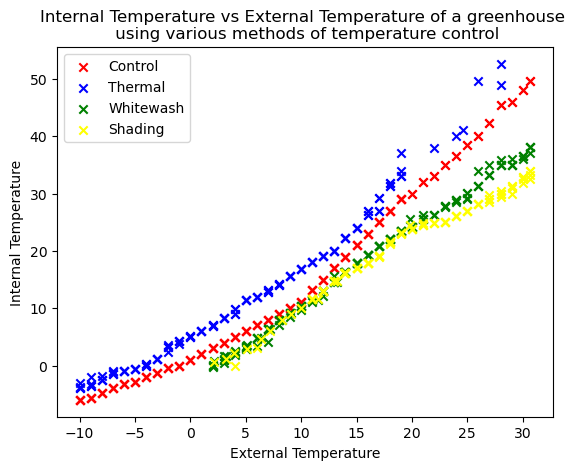

In [19]:
# Set the parameters for the plot
x = df_tech['External']
y1 = df_tech['Control']
y2 = df_tech['Thermal']
y3 = df_tech['Whitewash']
y4 = df_tech['Shading']

# Plot the data
plt.scatter(x,y1, marker='x', color='red', label='Control')
plt.scatter(x,y2, marker='x', color='blue', label='Thermal')
plt.scatter(x,y3, marker='x', color='green', label='Whitewash')
plt.scatter(x,y4, marker='x', color='yellow', label='Shading')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using various methods of temperature control')
plt.legend()

# Show the plot
plt.show()


## 4. Finding the impact of the different thermal techniques

### 4.1 Impact of whitewash on the internal temperature of a greenhouse
Whitewashing is the traditional approach to cooling a greenhouse. Once temperatures start to rise in the spring a layer of white wash is painted onto the roof of the greenhouse. This whitewash reduces the amount of solar gain and cools the day time temperatures of the the greenhouse. The chart above shows that the relationship between the external temperature and the temperature inside a white washed greenhouse is basically linear (green markers). Visualising the whitewashing data on its own makes this relationship clearer and check if there are any missing values using `.info()`.




In [23]:
whitewash_data = df_tech[['Whitewash', 'External']]
whitewash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Whitewash  155 non-null    float64
 1   External   210 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


There are missing values so we'll use the `dropna` technique to remove them [(25)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html). 

In [24]:
whitewash_data = whitewash_data.dropna()

whitewash_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 52 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Whitewash  155 non-null    float64
 1   External   155 non-null    float64
dtypes: float64(2)
memory usage: 3.6 KB


Now we have a clean dataset. We can plot the data and see there is a clear linear relationship between the data.

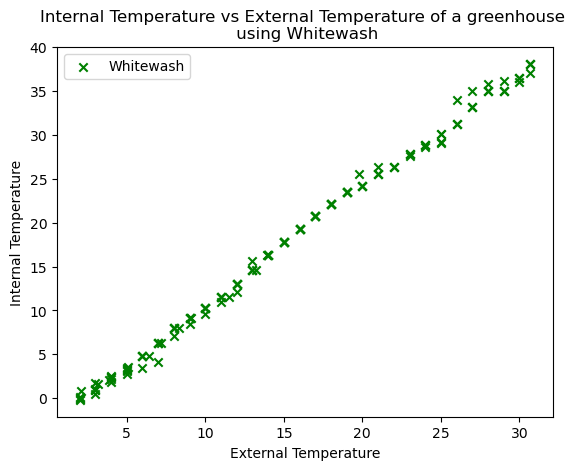

In [25]:
# Set the x and y values
x = whitewash_data['External']
y1 = whitewash_data['Whitewash']

# Plot the data
plt.scatter(x, y1, marker='x', color='green', label='Whitewash')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using Whitewash')
plt.legend()

# Show the plot
plt.show()

To assess the quality of the linear relationship we can complete a linear regression analysis and calculate the r-value using the stats import ([21])(https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html) and the linear regression function [(26)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). I have based my code on the example at [(27 w3 schools)](https://www.w3schools.com/python/python_ml_linear_regression.asp). 

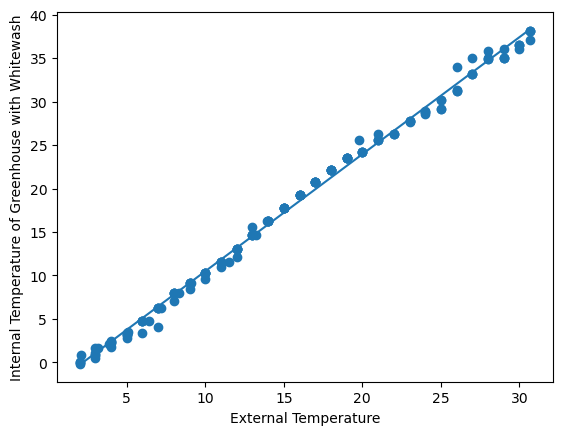

The R value is:  0.9981179494414084
The P value is:  2.0725328470034026e-187
The standard error is:  0.006689307022905101
The slope is:  1.3467361162582767
The intercept is:  -2.9829482950329833


In [ ]:
# Run the linear regression method from scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create a function to predict the internal temperature of a whitewashed greenhouse
def myfunc(x):
  return slope * x + intercept

# Run the function based on external temperature
mymodel = list(map(myfunc, x))

# Plot the data
plt.scatter(x, y1)
plt.plot(x, mymodel)
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of Greenhouse with Whitewash')

# Show the plot
plt.show()

# Print the results
print("The R value is: ", r_value)
print("The P value is: ", p_value)
print("The standard error is: ", std_err)
print("The slope is: ", slope)
print("The intercept is: ", intercept)

The high r-value shows there is a strong, linear relationship between the external temperature and internal temperature of a white washed greenhouse.

### 4.2 Impact of thermal curtains
When the data for the use of thermal curtains in the greenhouse is plotted there is a different type of relationship. At lower external temperatures the temperature is maintained at a higher level and when hotter this is exacerbated by the curtains. This type of trend is called polynomial [(28)](https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:poly-graphs/x2ec2f6f830c9fb89:poly-graphs-together/a/graphs-of-polynomials)

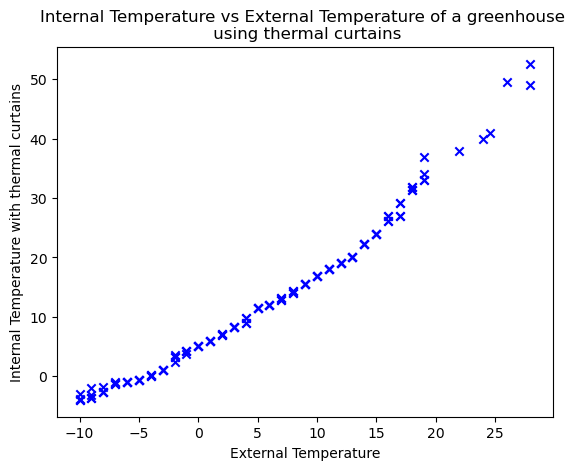

In [161]:
# Create a dataframe for the thermal curtain data
thermal_data = df_tech[['Thermal', 'External']]

# Drop any rows with missing data
thermal_data = thermal_data.dropna()

# Set the x and y values
x = thermal_data['External']
y2 = thermal_data['Thermal']

# Plot the data
plt.scatter(x, y2, marker='x', color='blue', label='Thermal')
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature with thermal curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using thermal curtains')

# Show the plot
plt.show()

To look at the trend and try to fit a line to we we can use `polyfit` in `numpy` [(29)], I based my code on this video tutorial [(https://www.youtube.com/watch?v=-Ovf9yAFhqI&ab_channel=ShameelAbdulla)](https://www.youtube.com/watch?v=-Ovf9yAFhqI&ab_channel=ShameelAbdulla).

The equation of the trend line is:          2
0.02225 x + 1.029 x + 4.544


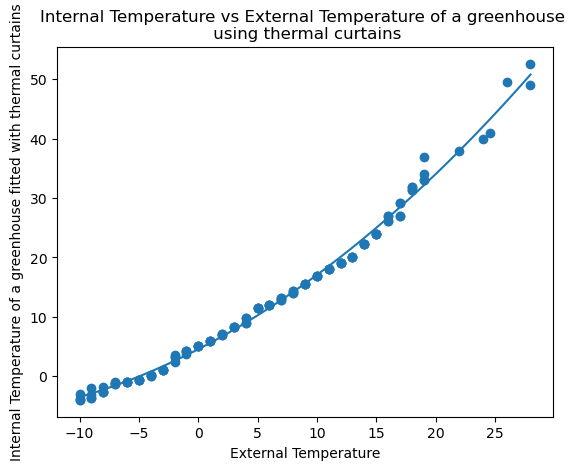

In [163]:
# Using numpy to create a polynomial regression
p = np.polyfit(x, y2, 2)
fit = np.poly1d(p)
print(f"The equation of the trend line is: {fit}")

# Plot the regression line
x_new = np.linspace(x.min(), x.max(), 100)
y_model = fit(x_new)

# Plot the data
plt.scatter(x, y2)
plt.plot(x_new, y_model)

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of a greenhouse fitted with thermal curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using thermal curtains')
plt.show()


### 4.3 Impact of shading
The plot of the data again shows a slight polynomial fit, perhaps as the shading curtains also act as a low-level insulator.


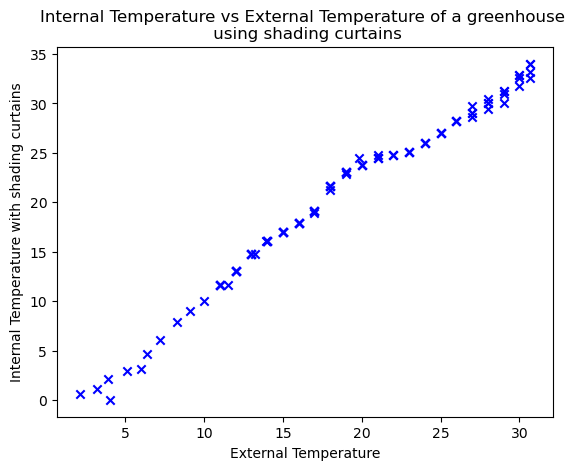

In [47]:
# Create a dataframe for the thermal curtain data
shading_data = df_tech[['Shading', 'External']]

# Drop any rows with missing data
shading_data = shading_data.dropna()

# Set the x and y values
x = shading_data['External']
y3 = shading_data['Shading']

# Plot the data
plt.scatter(x, y3, marker='x', color='blue')
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature with shading curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using shading curtains')

# Show the plot
plt.show()

Once again using `numpy polyfit` we can understand the relationship between the external temperature and the internal temperature of a greenhouse using shading curtains.

The equation of the trend line is:
           2
-0.01653 x + 1.734 x - 5.173


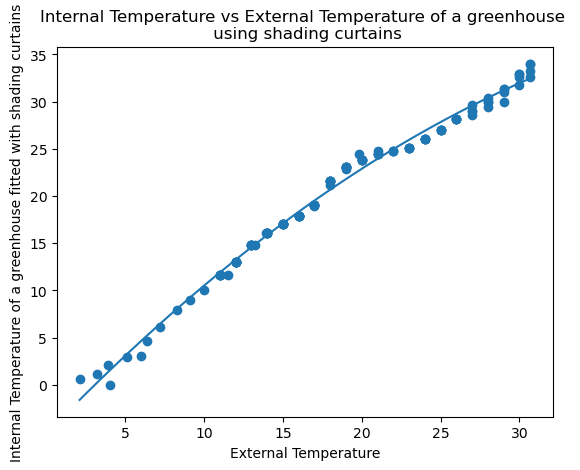

In [50]:
# Using numpy to create a polynomial regression
p = np.polyfit(x, y3, 2)
fit2 = np.poly1d(p)
print(f"The equation of the trend line is:\n {fit2}")

# Plot the regression line
x_new = np.linspace(x.min(), x.max(), 100)
y_model = fit2(x_new)

# Plot the data
plt.scatter(x, y3)
plt.plot(x_new, y_model)

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of a greenhouse fitted with shading curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using shading curtains')
plt.show()


### 4.4 Impact of a greenhouse on growing temperatures

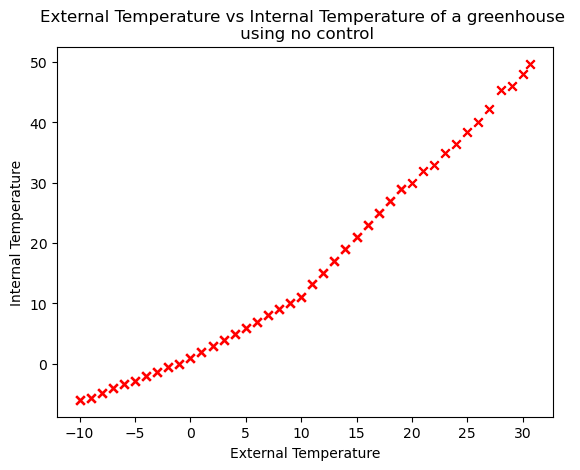

In [193]:
# Create a slice of the dataframe with the control data
control_data = df_tech[['Control', 'External']]

# Drop any rows with missing data
control_data = control_data.dropna()

# Set the x and y values
x = control_data['External']
y1 = control_data['Control']

# Plot the data
plt.scatter(x, y1, marker='x', color='red', label='Control')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('External Temperature vs Internal Temperature of a greenhouse \n using no control')   

# Show the plot
plt.show()

The equation of the trend line is:
          2
0.02248 x + 0.9405 x + 1.082


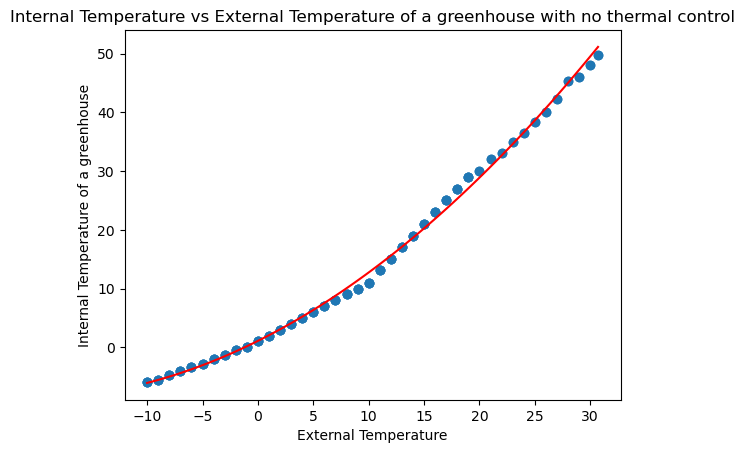

In [195]:
# Using numpy to create a polynomial regression
p = np.polyfit(x, y1, 2)
fit3 = np.poly1d(p)
print(f"The equation of the trend line is:\n {fit3}")

# Plot the regression line
x_new = np.linspace(x.min(), x.max(), 100)
y_model = fit3(x_new)

# Plot the data
plt.scatter(x, y1)
plt.plot(x_new, y_model, color='red')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of a greenhouse')
plt.title('Internal Temperature vs External Temperature of a greenhouse with no thermal control')
plt.show()


## 5. Create a database to store the weather data
Due to the large amounts of data needed for this analysis. A MySQL database needs to be created. MySQL offers the ability to store very large amounts of data in a structured and easily accessible way, where the data is persistent. 

To create the database we first set the connection parameters for the database and create the cursor to enable the connection for making SQL queries[(3)](https://dev.mysql.com/doc/connector-python/en/). Then create the database.


In [51]:
# Set the parameters for the connection
db = msql.connect(host='localhost', user='root',password='')

# Create the cursor
cursor = db.cursor()

# Execute SQL query
cursor.execute('CREATE DATABASE weather')
print('The database "weather" has been created')

# Close the connection
cursor.close()
db.close()

The database "weather" has been created


### 5.1 Create a table for the weather station data
Within the database a table needs to be created for each of the data sources. The first table will hold a list of the weather stations [(30)](https://dev.meteostat.net/bulk/stations.html#endpoints). The data about all the weather stations is available at: https://bulk.meteostat.net/v2/stations/lite.json.gz. The code to create the database is based on the tutorial on havatpoint [(31)](https://www.javatpoint.com/python-mysql-creating-tables).

In [11]:
try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')

    # Check if the connection is established
    if con.is_connected():
        # Select the database
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        cursor.execute('DROP TABLE IF EXISTS stations_data')
        print('Creating table....')
        
        # Create the table
        sql = """CREATE TABLE stations_data 
            (id VARCHAR(10) PRIMARY KEY, 
            name JSON, 
            country CHAR(2), 
            region VARCHAR(10), 
            national_id VARCHAR(10), 
            wmo_id VARCHAR(10), 
            icao_id VARCHAR(10), 
            iata_id VARCHAR(25), 
            latitude DECIMAL(9,6), 
            longitude DECIMAL(9,6), 
            elevation INT, 
            timezone VARCHAR(25),
            history JSON, 
            hourly_start DATE, 
            hourly_end DATE, 
            daily_start DATE,
            daily_end DATE,
            monthly_start YEAR,
            monthly_end YEAR,
            normals_start YEAR,
            normals_end YEAR
)"""
        cursor.execute(sql)
        print("Table is created....")

# Handle any errors
except msql.Error as err:
    print(err.msg)

# Close the cursor and connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()

You're connected to database: ('weather',)
Creating table....
Table is created....


### 5.2 Read in the weather station data
Then the weather stations table needs to be populated.It is compressed using `gzip` [(32](https://www.gnu.org/software/gzip/) so the file needs to be decompressed before creating the dataframe and inserting the information into the database. The code used here is based on information on stack overflow [(33)](https://stackoverflow.com/questions/39450065/python-3-read-write-compressed-json-objects-from-to-gzip-file). When adding the data to the table it is important to avoid SQL injection so the variables are passed in separately to the column names.

In [22]:
# File name and location
url = "https://bulk.meteostat.net/v2/stations/full.json.gz"
file_name = "full.json.gz"

# Download the file
response = requests.get(url, stream=True)
with open(file_name, 'wb') as f:
    f.write(response.content)

# Decompress the file
with gzip.open(file_name, 'rt', encoding='utf-8') as gz_file:
    stations_file = json.load(gz_file)

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Prepare SQL statement for data insertion
        sql_insert = """
            INSERT INTO stations_data (
                id, name, country, region, national_id, wmo_id, icao_id, iata_id,
                latitude, longitude, elevation, timezone, history,
                hourly_start, hourly_end, daily_start, daily_end,
                monthly_start, monthly_end, normals_start, normals_end
            ) VALUES (
                %(id)s, %(name)s, %(country)s, %(region)s, %(national_id)s, %(wmo_id)s, %(icao_id)s, %(iata_id)s,
                %(latitude)s, %(longitude)s, %(elevation)s, %(timezone)s, %(history)s,
                %(hourly_start)s, %(hourly_end)s, %(daily_start)s, %(daily_end)s,
                %(monthly_start)s, %(monthly_end)s, %(normals_start)s, %(normals_end)s
            )
        """

        # Insert Data into MySQL Table
        for station in stations_file:
            data = {
                'id': station.get('id'),
                'name': json.dumps(station.get('name', {})),  # Convert dictionary to JSON string
                'country': station.get('country'),
                'region': station.get('region'),
                'national_id': station.get('national'),
                'wmo_id': station.get('wmo'),
                'icao_id': station.get('icao'),
                'iata_id': station.get('iata'),
                'latitude': station.get('latitude'),
                'longitude': station.get('longitude'),
                'elevation': station.get('elevation'),
                'timezone': station.get('timezone'),
                'history': json.dumps(station.get('history', [])),  # Convert list to JSON string
                'hourly_start': station.get('inventory', {}).get('hourly', {}).get('start'),
                'hourly_end': station.get('inventory', {}).get('hourly', {}).get('end'),
                'daily_start': station.get('inventory', {}).get('daily', {}).get('start'),
                'daily_end': station.get('inventory', {}).get('daily', {}).get('end'),
                'monthly_start': station.get('inventory', {}).get('monthly', {}).get('start'),
                'monthly_end': station.get('inventory', {}).get('monthly', {}).get('end'),
                'normals_start': station.get('inventory', {}).get('normals', {}).get('start'),
                'normals_end': station.get('inventory', {}).get('normals', {}).get('end'),
            }
            cursor.execute(sql_insert, data)

        # Commit the transaction
        con.commit()
        print("Data inserted successfully.")

# Print details if an error occurs
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")

Connected to the database.
Data inserted successfully.
MySQL connection is closed.


### 5.3 Select the country of interest
Now we will extract data from the `stations_data` table looking for unique country values [(34)](https://www.w3schools.com/SQL/sql_distinct.asp). Using `fetchall` [(35)](https://www.geeksforgeeks.org/querying-data-from-a-database-using-fetchone-and-fetchall/) brings back all the results that fit the command and these can be printed to the screen.


In [23]:
# Connect to the MySQL Database
con = msql.connect(host='localhost', database='weather', user='root', password='')

# Create a cursor
cursor = con.cursor()

# Command to select the data from the table
sql = "SELECT DISTINCT country FROM stations_data"

# Execute the command
cursor.execute(sql)

# Fetch the results
results = cursor.fetchall()

# Print the results
print("The country codes are explained at: https://www.iban.com/country-codes")
print(f"The countries available are:")
for row in results:
    print(row)

# Close the cursor and connection
cursor.close()
con.close()

The country codes are explained at: https://www.iban.com/country-codes
The countries available are:
('CA',)
('NO',)
('SE',)
('FI',)
('DE',)
('GB',)
('IM',)
('IE',)
('IS',)
('GL',)
('US',)
('FO',)
('DK',)
('NL',)
('XA',)
('BE',)
('FR',)
('LU',)
('CH',)
('CN',)
('LI',)
('PT',)
('ES',)
('GI',)
('CV',)
('AU',)
('AT',)
('CZ',)
('SK',)
('PL',)
('HU',)
('RS',)
('SI',)
('HR',)
('XK',)
('BA',)
('CS',)
('MK',)
('AL',)
('RO',)
('BG',)
('IT',)
('MT',)
('GR',)
('TR',)
('CY',)
('RU',)
('EE',)
('LV',)
('LT',)
('BY',)
('KZ',)
('UA',)
('MD',)
('KG',)
('GE',)
('AZ',)
('AM',)
('UZ',)
('TM',)
('TJ',)
('SY',)
('LB',)
('IL',)
('PS',)
('JO',)
('SA',)
('QA',)
('KW',)
('IQ',)
('IR',)
('AF',)
('BH',)
('AE',)
('OM',)
('YE',)
('PK',)
('BD',)
('IN',)
('NP',)
('LK',)
('MV',)
('MN',)
('HK',)
('MO',)
('TW',)
('KP',)
('KR',)
('JP',)
('MM',)
('TH',)
('MY',)
('MX',)
('SG',)
('VN',)
('LA',)
('KH',)
('EH',)
('MA',)
('DZ',)
('TN',)
('LY',)
('NE',)
('ML',)
('MR',)
('SN',)
('GM',)
('GW',)
('GN',)
('SL',)
('SH',)
('AQ',)
('ST

Now the user can see the list of possible codes, they should be prompted to select the country of interest and the regions in that country returned.


In [24]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the country code
        chosencountry = input(str("Enter the country of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosencountry) != 2:
            print("Invalid country code. Please enter a valid 2- character country code.")
        else: # Exectute the SQL query
            query = sql = "SELECT DISTINCT region FROM stations_data WHERE country = %s"
            cursor.execute(query, (chosencountry,)) 
            
            # Fetch and display the results
            results = cursor.fetchall()
            if results:
                print(f"The regions within {chosencountry} available are:")
                for row in results:
                    print(row)
            else:
                print(f"No regions found for country code: {chosencountry}")
                
except msql.Error as err:
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()


The regions within CA available are:
('AB',)
('MB',)
('BC',)
('SK',)
('NU',)
('ON',)
('YT',)
('QC',)
('NS',)
('NL',)
('NT',)
('PE',)
('NB',)
('SD',)
('NF',)


### 5.4 Select the weather stations in the country and region of interest
Using the selected country and region the station ids are returned, these are returned as a string for using later. The query is created with dynamic components so different country and region data can be handled.

In [25]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the region code
        chosenregion = input(str("Enter the region of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosenregion) != 2:
            print("Invalid region code. Please enter a valid 2- character region code.")
        else: # Execute the SQL query
            query ="SELECT id FROM stations_data WHERE country = %s AND region = %s AND daily_start IS NOT NULL"
            cursor.execute(query, (chosencountry, chosenregion,)) 
            
            # Fetch and display the results
            station_ids = [str(row[0]) for row in cursor.fetchall()]
            # Print the results
            if results:
                print(f"The stations within {chosenregion} are:")
                for row in station_ids:
                    print(row)
            # If no results are found
            else:
                print(f"No stations found for region code: {chosenregion} in country code: {chosencountry}")
                
# Handle any errors
except msql.Error as err:
    print(err)

# Close the cursor and connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()

The stations within ON are:
0CNUO
0CO7B
0FV1F
0FV2W
10RIK
128HL
13178
17CKT
1D16Y
1J1PJ
1JWST
1Y8OJ
21O3U
2FXL8
2W8UZ
2XUGG
3EADS
3S56J
44BUQ
4DA9G
4DUJO
5MKGL
5RUZT
65YVF
6N2T2
71063
71099
71151
71161
71171
71172
71193
71260
71261
71262
71263
71265
71270
71272
71281
71282
71290
71291
71292
71294
71295
71296
71297
71298
71299
71300
71301
71303
71307
71309
71314
71352
71368
71369
71399
71430
71431
71432
71433
71434
71435
71436
71437
71438
71439
71460
71462
71463
71464
71465
71466
71468
71508
71527
71534
71538
71559
71573
71581
71582
71620
71621
71623
71624
71625
71628
71629
71630
71631
71632
71633
71639
71642
71655
71660
71667
71672
71694
71697
71704
71730
71731
71733
71735
71738
71739
71747
71749
71750
71751
71752
71755
71767
71820
71831
71832
71834
71835
71836
71841
71842
71844
71845
71846
71850
71854
71956
71962
75BU2
7FGUJ
7L5OL
7PXZ6
7Q717
7ZTNB
82JYP
86WK3
8HNVP
8IOCM
8PJPB
8TSI8
8WZUG
93RHE
9GNQU
9H92X
9HC7K
9K6D9
9M4XD
9W5OW
ADBC1
AE2A1
ATA0X
BI2NY
CNR66
CTAL0
CTCK0
CTGT0
CTWN0


### 5.5 Create a table for the weather data for each region
Due to the user input of the country and region the code dynamic fields are added to out base code used in [(5.1)](#51-create-a-table-for-the-weather-station-data) to account for these values.

In [26]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    
    # Check if the connection is established
    if con.is_connected():
        
        # Select the database
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        drop_query = f"DROP TABLE IF EXISTS `{table_name}`"
        cursor.execute(drop_query)
        print(f"Table '{table_name}' dropped if it existed.")
        
        # Create the table
        create_query = f"""
        CREATE TABLE `{table_name}` (
            id VARCHAR(10) PRIMARY KEY, 
            station_id VARCHAR(10),
            date DATE,
            avg_temp DECIMAL(5,1), 
            min_temp DECIMAL(5,1),
            max_temp DECIMAL(5,1),
            month INT,
            year YEAR
        )
        """
        cursor.execute(create_query)
        
        # Print the success message
        print(f"Table '{table_name}' is created successfully.")

# Handle any errors
except msql.Error as err:
    print(err.msg)

# Close the cursor and connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()

You're connected to database: ('weather',)
Table 'ca_on_data' dropped if it existed.
Table 'ca_on_data' is created successfully.


### 5.6 Add the weather station data for the chosen region 
Now the table needs to be populated with the data for each of the weather stations in the chosen country and region. The code will add a column for the station ID, month and year as this is used in most of the data processing. Any blank rows are dropped using `dropna` [(25)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html). `iterrows` is used to iterate over the dataframe to correctly insert it into the table [(36)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html)

In [27]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Insert Data into MySQL Table
        for station in station_ids:
            print(f"Processing station: {station}")

            # Download the file
            url = f"https://bulk.meteostat.net/v2/daily/{station}.csv.gz"
            response = requests.get(url)
            response.raise_for_status()  # Ensure the request was successful

            if response.status_code == 200:
                # Read the CSV file into a DataFrame
                stations_data = gzip.GzipFile(fileobj=BytesIO(response.content))
                df = pd.read_csv(stations_data, usecols=[0, 1, 2, 3], names=['date', 'avg_temp', 'min_temp', 'max_temp'], parse_dates=['date'])
                # Drop rows with missing values
                df.dropna(inplace=True)

                # Add a station ID column
                df['station_id'] = station

                # Add month and year columns
                df["year"] = df["date"].dt.year
                df["month"] = df["date"].dt.month

                counter = 0
                for _, row in df.iterrows():
                    # Create a unique ID for each row
                    id = f"{row['station_id']}_{counter}"
                    
                    # Prepare SQL statement for data insertion
                    sql_insert = f"""
            INSERT INTO `{table_name}` (id, station_id, date, avg_temp, min_temp, max_temp, month, year) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """
                    # Insert data into MySQL table
                    cursor.execute(sql_insert,(
                        id,
                        row["station_id"],
                        row["date"].date(),
                        row.get("avg_temp", None),
                        row.get("min_temp", None),
                        row.get("max_temp", None),
                        row["month"],
                        row["year"],
                    ))
                    # Increment the counter
                    counter += 1
                # Commit the transaction    
                con.commit()
                print(f"Data from station {station} inserted successfully.")
            # If the request was not successful
            else:
                print(f"Failed to download data for station: {station}")
# Handle any errors
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")

Connected to the database.
Processing station: 0CNUO
Data from station 0CNUO inserted successfully.
Processing station: 0CO7B
Data from station 0CO7B inserted successfully.
Processing station: 0FV1F
Data from station 0FV1F inserted successfully.
Processing station: 0FV2W
Data from station 0FV2W inserted successfully.
Processing station: 10RIK
Data from station 10RIK inserted successfully.
Processing station: 128HL
Data from station 128HL inserted successfully.
Processing station: 13178
Data from station 13178 inserted successfully.
Processing station: 17CKT
Data from station 17CKT inserted successfully.
Processing station: 1D16Y
Data from station 1D16Y inserted successfully.
Processing station: 1J1PJ
Data from station 1J1PJ inserted successfully.
Processing station: 1JWST
Data from station 1JWST inserted successfully.
Processing station: 1Y8OJ
Data from station 1Y8OJ inserted successfully.
Processing station: 21O3U
Data from station 21O3U inserted successfully.
Processing station: 2FXL

## 6. The test plants
The test plants used for the analyses of extra growing days from using the different thermal techniques on the greenhouses are: lettuce and tomatoes. "Head lettuce is the most important salad vegetable gown in the United States" [(40)](https://content.ces.ncsu.edu/lettuce). The optimum growing temperature for head lettuce is 15-18°C. At 20-26°C the plants start to flower and produce seed and need replacing and temperatures below 0°C will kill the plants. Variables are created to store this information.


In [28]:
lettuce_min = 0
lettuce_max = 20
lettuce_range_low = 15
lettuce_range_high = 18

Tomatoes are grown across the world and are an important staple in many cuisines. To increase their range and season many are grown in greenhouses. The optimal conditions for growth are 21-27°C with temperatures not dropping below 16°C or exceeding 29°C [(41)](https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/).

In [63]:
tomato_min = 16
tomato_max = 29
tomato_range1 = 21
tomato_range2 = 27

## 7. Analysing the weather data
The first step is to visualise the weather data. For user ease a front end could be built which requests the country and region of interest and checks if the data is available, if so, the data for one of the weather stations can be extracted.


In [170]:

chosencountry = input(str("Enter the country of interest, using the two digit code: "))
chosenregion = input(str("Enter the region of interest, using the two digit code: "))

Use this choice to extract the daily average temperature data for the station of interest from the database.

In [285]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    
    # If the connection is established
    if con.is_connected():
        cursor = con.cursor()
        
        #Request user to input the station ID
        chosenstation = input(str("Enter the station ID of interest: ").strip().upper())
        
        # Check if the station ID is valid
        if chosenstation in station_ids:
            print(f"Station {chosenstation} is available.")
        
        # If the station ID is not valid
        else:
            print(f"Please choose from one of the following station IDs: {station_ids}")
        
        # Execute the SQL query
        query =f"SELECT date, avg_temp, min_temp, max_temp, month, year FROM `{table_name}` WHERE station_id = %s"
        cursor.execute(query, (chosenstation,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df= pd.DataFrame(rows)
        
        # Add column names
        df.columns=['date', 'avg_temp', 'min_temp', 'max_temp', 'month', 'year']
        
        # Print the first 5 rows
        print(df.head(5))

# Handle any errors
except msql.Error as err: 
    print(err)

# Close the cursor and connection
finally:
    if con and con.is_connected():
        cursor.close()
        con.close()

Station 10RIK is available.
         date avg_temp min_temp max_temp  month  year
0  2000-01-01     -2.5    -11.0      6.0      1  2000
1  2000-01-02      5.0     -2.0     12.0      1  2000
2  2000-01-03     -0.3     -2.0      1.5      1  2000
3  2000-01-04      4.5     -2.0     11.0      1  2000
4  2000-01-05     -8.8    -11.5     -6.0      1  2000


### 7.1 Average temperature data by month
To calculate the monthly average temperature for the weather station `dataframe.groupby` [(37)](https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/) and `.mean()` [(38)](https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.core.groupby.GroupBy.mean.html) can be used. To enable the each years information to be overlayed `.unique()` is used to extract the year covered by the dataset [(39)](https://pandas.pydata.org/docs/reference/api/pandas.unique.html). Horizontal lines [(42)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html#matplotlib.pyplot.axhline) have been added to the plot to show the preferred growing conditions for lettuce as set out in [Section 6](#6-the-test-plants). The x tick names have been manually set to the months of the year rather than displaying numerically so it is easier to read [(43)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html). Due to the complexity of the plot legend the location has been set using `bbox_to_anchor` to control its location [(44)](https://www.geeksforgeeks.org/how-to-place-legend-outside-of-the-plot-in-matplotlib/)



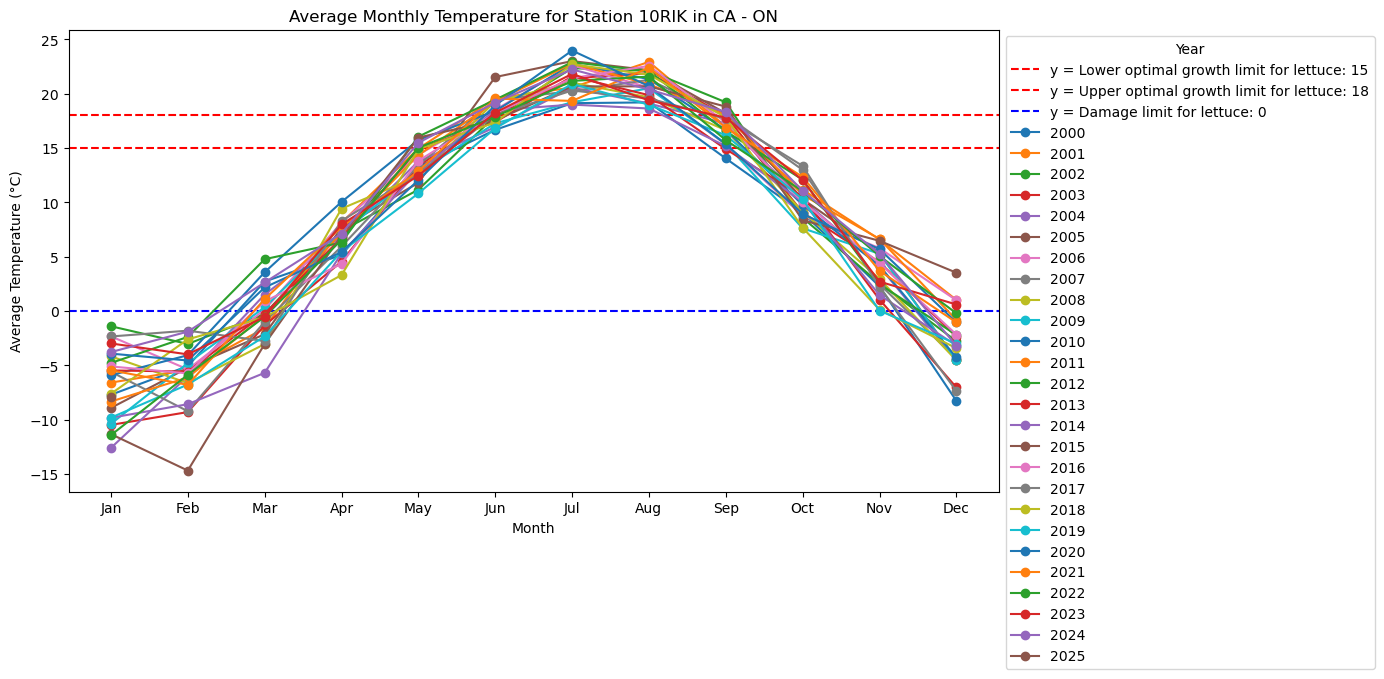

In [64]:
# Group by year and month, then calculate the average temperature for each month
monthly_avg = df.groupby(["year", "month"])["avg_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range_low, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range_low}')
plt.axhline(y=lettuce_range_high, color='r', linestyle='--', label=f'y = Upper optimal growth limit for lettuce: {lettuce_range_high}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')

# Iterate over each year and plot the data
for year in years:
    year_data = monthly_avg[monthly_avg["year"] == year]
    plt.plot(year_data["month"], year_data["avg_temp"], marker="o", label=str(year))

# Label the chart
plt.title(f"Average Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


Due to the large number of years of data, this plot is still quite complex and could be simplified by combining the data into 5 year groups. This gives a very long dataframe with year month for every put on a row. To make plotting easier the data can be pivoted to the row title is the month and the column the 5-year period [(45)](https://www.qodo.ai/blog/pandas-pivot-tables-a-comprehensive-guide-for-data-science/#:~:text=The%20pivot()%20function%20is,and%20a%20specified%20values%20column.) To iterate through the data for plotting `.columns()` is used to find the column name [(46)](https://stackoverflow.com/questions/23546555/in-pandas-whats-the-difference-between-dfcolumn-and-df-column).

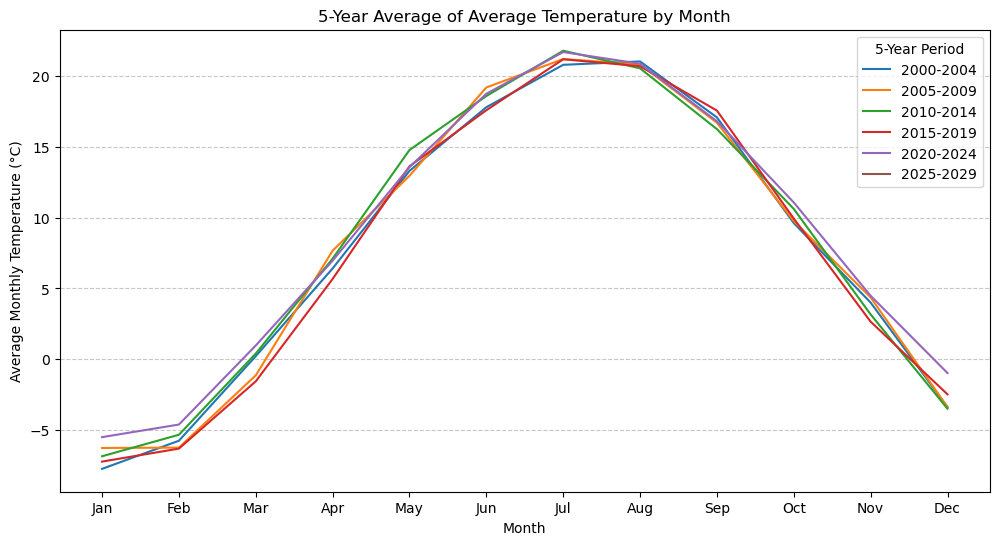

In [65]:
# Add a column for 5-year bins
monthly_avg["5_year_period"] = (monthly_avg["year"] // 5) * 5

# Calculate the 5-year average for each month
monthly_averages = (
    monthly_avg.groupby(["5_year_period", "month"])["avg_temp"]
    .mean()
    .reset_index()
)

# Pivot the data for easier plotting
pivot_table = monthly_averages.pivot(index="month", columns="5_year_period", values="avg_temp")

# Plot the chart
plt.figure(figsize=(12, 6))

# Plot each 5-year period as a line
for period in pivot_table.columns:
    plt.plot(
        pivot_table.index,
        pivot_table[period],
        label=f"{period}-{period + 4}"
    )

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Average Monthly Temperature (°C)")
plt.title("5-Year Average of Average Temperature by Month")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="5-Year Period")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 7.2 Average minimum temperatures
A similar approach can be taken to plot the average minimum temperature for the location. The chart shows that in November to March the average outside temperatures are far too low to grow lettuce and only June to August has temperatures suitable for growing lettuce outdoors.

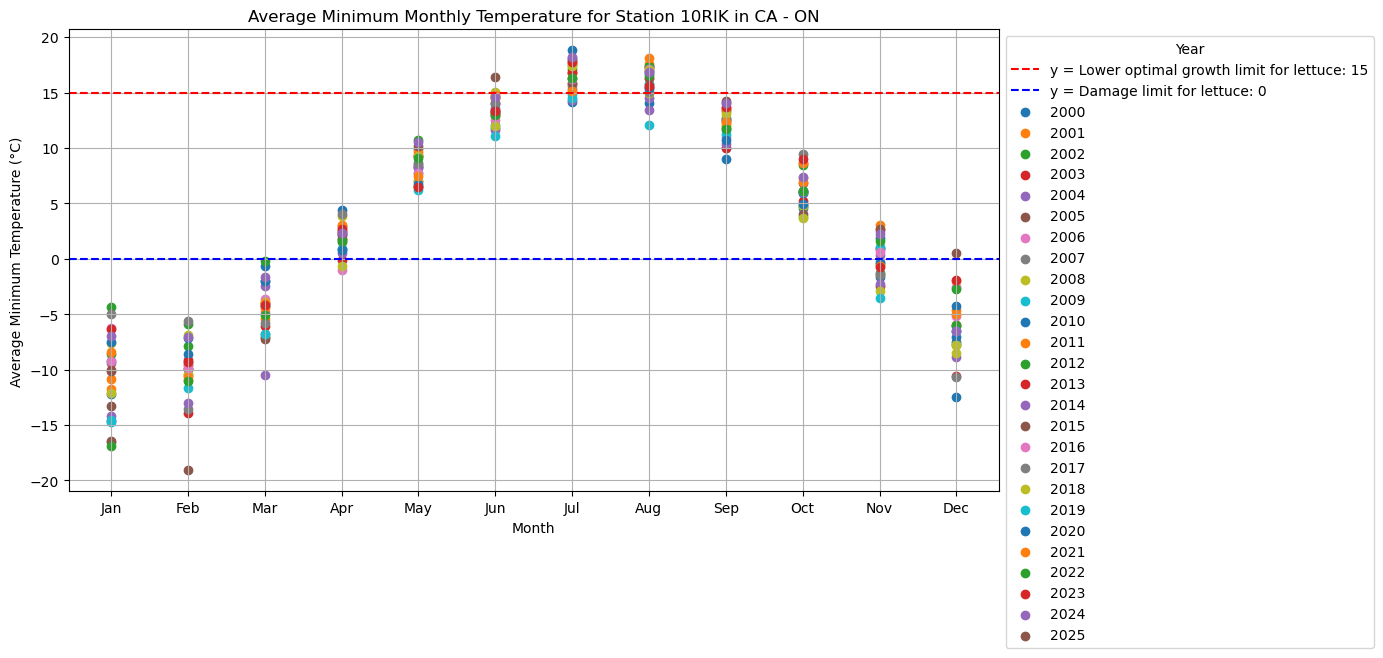

In [72]:
# Drop any rows with missing values in the min_temp column
df.dropna(subset=['min_temp'], inplace=True)

# Group by year and month, then calculate the minimum average temperature for each month
min_monthly_avg = df.groupby(["year", "month"])["min_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = min_monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range_low, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range_low}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')

# Plot the data
for year in years:
    year_data = min_monthly_avg[min_monthly_avg["year"] == year]
    plt.scatter(year_data["month"], year_data["min_temp"], marker="o", label=str(year))

# Label the chart
plt.title(f"Average Minimum Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]) # Set the x ticks to months as words
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1)) # Create a legend

plt.grid(True)
plt.show()

### 7.3 Average temperature for the region
To enable more broad stroke analysis a whole region's data could be analysed at once. First the entire table for the region needs to be called.

In [169]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    
    # If the connection is established
    if con.is_connected():
        cursor = con.cursor()
         
        # Execute the SQL query
        query =f"SELECT date, avg_temp, month, year FROM `{table_name}`"
        cursor.execute(query, )
        rows = cursor.fetchall()
        
        # Create a DataFrame
        region_df= pd.DataFrame(rows)
        
        # Add column names
        region_df.columns=['date', 'avg_temp', 'month', 'year']
        
        # Print the first 5 rows
        print(region_df.head(5))

# Handle any errors
except msql.Error as err: 
    print(err)

# Close the cursor and connection
finally:
    if con and con.is_connected():
        cursor.close()
        con.close()

         date avg_temp  month  year
0  2000-01-01    -17.5      1  2000
1  2000-01-02    -14.5      1  2000
2  2000-01-03    -16.0      1  2000
3  2000-01-04    -21.3      1  2000
4  2000-01-05    -16.8      1  2000


Then this data transformed as in [(section 7.1)](#71-average-temperature-data-by-month) to plot all the data into 5 year grouping and averaged by month.

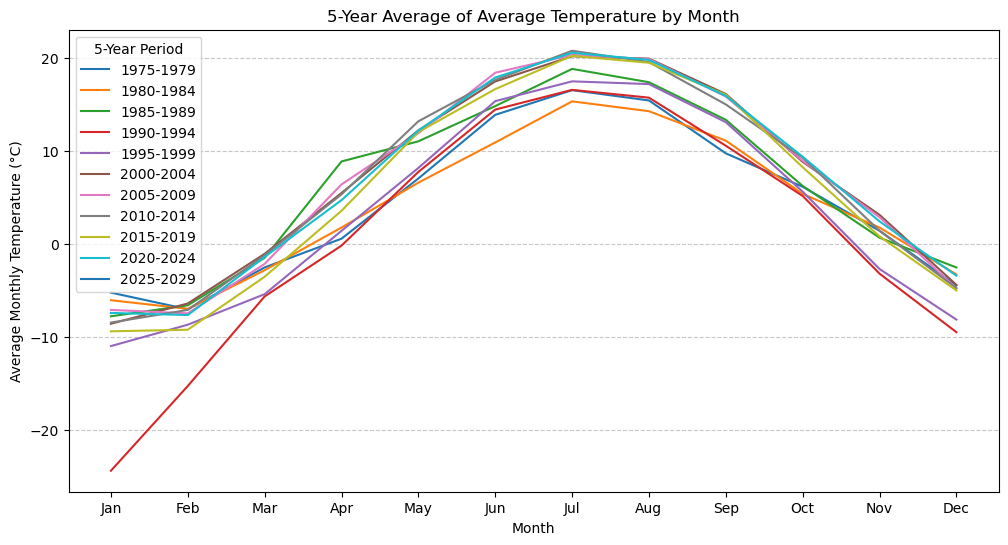

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [79]:
# Group by year and month, then calculate the average temperature for each month
monthly_avg_region = region_df.groupby(["year", "month"])["avg_temp"].mean().reset_index()

# Add a column for 5-year bins
monthly_avg_region["5_year_period"] = (monthly_avg_region["year"] // 5) * 5

# Calculate the 5-year average for each month
monthly_averages_region = (
    monthly_avg_region.groupby(["5_year_period", "month"])["avg_temp"]
    .mean()
    .reset_index()
)

# Pivot the data for easier plotting
pivot_table_regions = monthly_averages_region.pivot(index="month", columns="5_year_period", values="avg_temp")

# Plot the chart
plt.figure(figsize=(12, 6))

# Plot each 5-year period as a line
for period in pivot_table_regions.columns:
    plt.plot(
        pivot_table_regions.index,
        pivot_table_regions[period],
        label=f"{period}-{period + 4}"
    )

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Average Monthly Temperature (°C)")
plt.title("5-Year Average of Average Temperature by Month")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="5-Year Period")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
# Plot the data
plt.figure(figsize=(12, 6))



## 8. Analysing the impact of different thermal techniques on greenhouse temperatures at a particular location
In [sections 4](#4-finding-the-impact-of-the-different-thermal-techniques), [5](#5-create-a-database-to-store-the-weather-data) and [6](#6-the-test-plants) we have stored the knowledge needed to predict the impact of different thermal techniques on greenhouse temperatures based on the external temperatures. With the weather data for a particular location we can predict the impact of the thermal techniques for nearby greenhouses. Using station 10RIK as in section [7.1](#71-average-temperature-data-by-month) we can perform a number of analyses to calculate the number of cold days and the impact of thermal curtains on these as well as the number of hot days and the impact of shading and whitewashing.

### 8.1 Calculate the number of hot and cold days
For this we are once again going to assume that lettuce is the crop of interest and use the variables set out in section [6](#6-the-test-plants). 

In [256]:
# Calculate the number of cold days
df["cold_day"] = df["avg_temp"] < lettuce_range_low

# Calculate the number of hot days
df["hot_day"] = df["avg_temp"] > lettuce_range_high

# Get the unique years
years = df["year"].unique()

# Print the dataframe to check the new columns
print(df.head())

        date  avg_temp min_temp max_temp  month  year  greenhouse_temp  \
0 2000-01-01      -2.5    -11.0      6.0      1  2000        -3.314745   
1 2000-01-02       5.0     -2.0     12.0      1  2000         5.158351   
2 2000-01-03      -0.3     -2.0      1.5      1  2000        -0.829303   
3 2000-01-04       4.5     -2.0     11.0      1  2000         4.593478   
4 2000-01-05      -8.8    -11.5     -6.0      1  2000       -10.432146   

   temp_whitewash  thermal_curtain_temp  cold_day  hot_day  
0       -3.314745              2.109912      True    False  
1        5.158351             10.245939      True    False  
2       -0.829303              4.237046      True    False  
3        4.593478              9.625663      True    False  
4      -10.432146             -2.789946      True    False  


### 8.2 Calculate the internal temperature of a greenhouse in this location
The relationship between the external temperature and the internal temperature of a greenhouse was calculated in section [4.4](#44-impact-of-a-greenhouse)

In [257]:
print(fit3)

         2
0.02248 x + 0.9405 x + 1.082


Create a new column in the dataframe to store the internal temperatures in a greenhouse in this location.

In [286]:
x = df["avg_temp"].astype(float)
df["greenhouse_temp"] = fit3(x)

print(df)


            date avg_temp min_temp max_temp  month  year  greenhouse_temp
0     2000-01-01     -2.5    -11.0      6.0      1  2000        -1.128520
1     2000-01-02      5.0     -2.0     12.0      1  2000         6.346967
2     2000-01-03     -0.3     -2.0      1.5      1  2000         0.802132
3     2000-01-04      4.5     -2.0     11.0      1  2000         5.769909
4     2000-01-05     -8.8    -11.5     -6.0      1  2000        -5.453218
...          ...      ...      ...      ...    ...   ...              ...
9070  2025-01-07    -10.0    -12.9     -8.2      1  2025        -6.074619
9071  2025-01-08    -13.6    -16.0    -11.6      1  2025        -7.550307
9072  2025-01-09    -11.2    -13.6     -8.5      1  2025        -6.631267
9073  2025-01-10    -10.0    -12.8     -7.3      1  2025        -6.074619
9074  2025-01-11     -6.3     -8.6     -3.8      1  2025        -3.950661

[9075 rows x 7 columns]


### 8.3 Calculate the internal temperature of a greenhouse using whitewash
The relationship between the external temperature and the internal temperature of a white washed greenhouse was worked on in section [4.1](#41-whitewash)

In [259]:
print(f"The relationship between the internal temperatures of a greenhouse and the external temperatures is: {slope}x + {intercept}. Where x is the external temperature.")

The relationship between the internal temperatures of a greenhouse and the external temperatures is: 1.1297461924234886x + -0.49037957890127615. Where x is the external temperature.


To calculate the internal temperature of a whitewashed greenhouse built in our weather stations location we need to pass the average temperature data into this equation. This equation should only be applied to temperatures between April and October (the common time for whitewashing greenhouses in this locality) otherwise the greenhouse temperature should be stored.

In [287]:
# Ensure the 'date' column is in datetime format
df["date"] = pd.to_datetime(df["date"])

# Ensure the 'avg_temp' column is in float format
df["avg_temp"] = df["avg_temp"].astype(float)

# Define the formula function from section 4.4
def apply_whitewash(temp):
    return float(slope * temp + intercept)

# Apply the formula only for dates within the range
df["temp_whitewash"] = df.loc[(df["date"].dt.month >= 4) & (df["date"].dt.month <= 10), "temp_whitewash"] = df["avg_temp"].apply(apply_whitewash)

# Create the temp_wash column based on the condition
df["temp_whitewash"] = np.where(
    (df["date"].dt.month >= 4) & (df["date"].dt.month <= 10),  # Between April and October
    df["avg_temp"].apply(apply_whitewash),  # Apply the function
    df["greenhouse_temp"]  # Otherwise, use the greenhouse column
)

print(df.head())

        date  avg_temp min_temp max_temp  month  year  greenhouse_temp  \
0 2000-01-01      -2.5    -11.0      6.0      1  2000        -1.128520   
1 2000-01-02       5.0     -2.0     12.0      1  2000         6.346967   
2 2000-01-03      -0.3     -2.0      1.5      1  2000         0.802132   
3 2000-01-04       4.5     -2.0     11.0      1  2000         5.769909   
4 2000-01-05      -8.8    -11.5     -6.0      1  2000        -5.453218   

   temp_whitewash  
0       -1.128520  
1        6.346967  
2        0.802132  
3        5.769909  
4       -5.453218  


White wash is applied when the temperatures for 5 days consequitively above a threshold and removed when the reverse is true. This is normally once per year.


### 8.4 Calculate the internal temperature of a greenhouse using thermal shades
Repeat the process above for thermal shades when the temperature inside the greenhouse. This relationship was explored in section [4.2](#42-impact-of-thermal-curtains). This time the relationship is polynomial.

The model should calculate the thermal shade temperature assuming the shades are active when the greenhouse temperature exceeds the lower optimal growth limit for lettuce. 

In [261]:
print(fit)

         2
0.02225 x + 1.029 x + 4.544


Again we use this data to predict the internal temperature of a greenhouse with thermal curtains. `numpy.where` has been used to handle the conditions to modify the temperature when the greenhouse temperature meets a set limit [(47)](https://www.geeksforgeeks.org/numpy-where-in-python/).

In [288]:
x = df["avg_temp"].astype(float)

# Populate the thermal_curtain_temp column for greenhouse temperatures over the lower optimal growth limit for lettuce
df["thermal_curtain_temp"] = np.where(df["greenhouse_temp"] < lettuce_range_low, fit(x), df["greenhouse_temp"])
print(df)

           date  avg_temp min_temp max_temp  month  year  greenhouse_temp  \
0    2000-01-01      -2.5    -11.0      6.0      1  2000        -1.128520   
1    2000-01-02       5.0     -2.0     12.0      1  2000         6.346967   
2    2000-01-03      -0.3     -2.0      1.5      1  2000         0.802132   
3    2000-01-04       4.5     -2.0     11.0      1  2000         5.769909   
4    2000-01-05      -8.8    -11.5     -6.0      1  2000        -5.453218   
...         ...       ...      ...      ...    ...   ...              ...   
9070 2025-01-07     -10.0    -12.9     -8.2      1  2025        -6.074619   
9071 2025-01-08     -13.6    -16.0    -11.6      1  2025        -7.550307   
9072 2025-01-09     -11.2    -13.6     -8.5      1  2025        -6.631267   
9073 2025-01-10     -10.0    -12.8     -7.3      1  2025        -6.074619   
9074 2025-01-11      -6.3     -8.6     -3.8      1  2025        -3.950661   

      temp_whitewash  thermal_curtain_temp  
0          -1.128520          

### 8.5 Calculate the impact of light shades
The relationship between the external temperature and light shades was calculated in section [4.3](#43-impact-of-shading).

In [263]:
print(fit2)

          2
-0.01653 x + 1.734 x - 5.173


In [289]:
# Populate the thermal_curtain_temp column for greenhouse temperatures over the lower optimal growth limit for lettuce
df["shading_temp"] = np.where(df["greenhouse_temp"] > lettuce_range_low, fit2(x), df["greenhouse_temp"])

print(df.head())

        date  avg_temp min_temp max_temp  month  year  greenhouse_temp  \
0 2000-01-01      -2.5    -11.0      6.0      1  2000        -1.128520   
1 2000-01-02       5.0     -2.0     12.0      1  2000         6.346967   
2 2000-01-03      -0.3     -2.0      1.5      1  2000         0.802132   
3 2000-01-04       4.5     -2.0     11.0      1  2000         5.769909   
4 2000-01-05      -8.8    -11.5     -6.0      1  2000        -5.453218   

   temp_whitewash  thermal_curtain_temp  shading_temp  
0       -1.128520              2.109912     -1.128520  
1        6.346967             10.245939      6.346967  
2        0.802132              4.237046      0.802132  
3        5.769909              9.625663      5.769909  
4       -5.453218             -2.789946     -5.453218  


### 8.6 Plot the temperature data for the different thermal methods

Text(0.5, 1.0, 'Internal Temperature vs External Temperature of a greenhouse \n using various methods of temperature control')

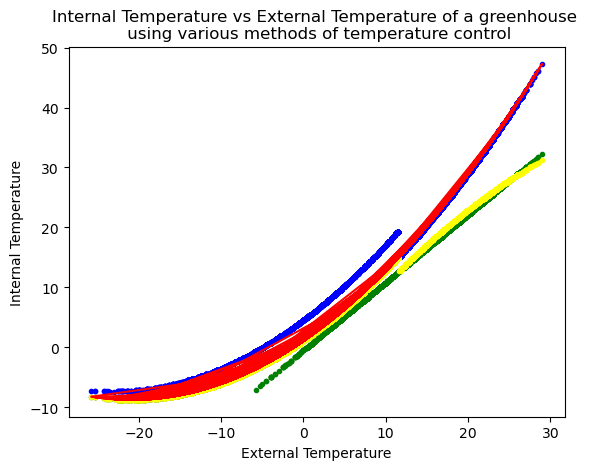

In [290]:
x = df["avg_temp"]
y = df["greenhouse_temp"]
y1 = df["temp_whitewash"]
y2 = df["thermal_curtain_temp"]
y3 = df["shading_temp"]

plt.plot(x, y, color = 'red', label='Control')
plt.scatter(x, y1, marker='.', color='green', label='Whitewash')
plt.scatter(x, y2, marker='.', color='blue', label='Thermal Curtain')   
plt.scatter(x, y3, marker='.', color='yellow', label='Shade Curtain')

plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using various methods of temperature control')  

### 8.7 Extra growing days
The importance for growers making decisions about paying for expensive greenhouses and thermal management techniques is whether they deliver extra growing days.

In [291]:
# Add a column for each method to indicate if the temperature is optimal
df["optimal_temp"] = np.where((df["avg_temp"] > lettuce_range_low) & (df["avg_temp"] < lettuce_range_high), "Optimal", "Not Optimal")
df['optimal_temp_greenhouse']  = np.where((df['greenhouse_temp'] > lettuce_range_low) & (df['greenhouse_temp'] < lettuce_range_high), 'Optimal', 'Not Optimal')
df['optimal_temp_whitewash']  = np.where((df['temp_whitewash'] > lettuce_range_low) & (df['temp_whitewash'] < lettuce_range_high), 'Optimal', 'Not Optimal')
df['optimal_temp_thermal']  = np.where((df['thermal_curtain_temp'] > lettuce_range_low) & (df['thermal_curtain_temp'] < lettuce_range_high), 'Optimal', 'Not Optimal')
df['optimal_temp_shade']  = np.where((df['shading_temp'] > lettuce_range_low) & (df['shading_temp'] < lettuce_range_high), 'Optimal', 'Not Optimal')

print(df.head())

        date  avg_temp min_temp max_temp  month  year  greenhouse_temp  \
0 2000-01-01      -2.5    -11.0      6.0      1  2000        -1.128520   
1 2000-01-02       5.0     -2.0     12.0      1  2000         6.346967   
2 2000-01-03      -0.3     -2.0      1.5      1  2000         0.802132   
3 2000-01-04       4.5     -2.0     11.0      1  2000         5.769909   
4 2000-01-05      -8.8    -11.5     -6.0      1  2000        -5.453218   

   temp_whitewash  thermal_curtain_temp  shading_temp optimal_temp  \
0       -1.128520              2.109912     -1.128520  Not Optimal   
1        6.346967             10.245939      6.346967  Not Optimal   
2        0.802132              4.237046      0.802132  Not Optimal   
3        5.769909              9.625663      5.769909  Not Optimal   
4       -5.453218             -2.789946     -5.453218  Not Optimal   

  optimal_temp_greenhouse optimal_temp_whitewash optimal_temp_thermal  \
0             Not Optimal            Not Optimal          Not

In [292]:
# Calculate the number of optimal growing days per month and year for 'avg_temp', 'optimal_temp_greenhouse', 'optimal_temp_whitewash'
avg_temp = df.groupby(['year', 'month'])['avg_temp'].sum().reset_index(name='optimal_days')
optimal_days = df.groupby(['year'])['optimal_temp'].apply(lambda x: (x == 'Optimal').sum()).reset_index(name='optimal_days_avg_temp')
optimal_days_greenhouse = df.groupby(['year'])['optimal_temp_greenhouse'].apply(lambda x: (x == 'Optimal').sum()).reset_index(name='optimal_days_greenhouse')
optimal_days_whitewash = df.groupby(['year'])['optimal_temp_whitewash'].apply(lambda x: (x == 'Optimal').sum()).reset_index(name='optimal_days_whitewash')
optimal_days_thermal = df.groupby(['year'])['optimal_temp_thermal'].apply(lambda x: (x == 'Optimal').sum()).reset_index(name='optimal_days_thermal')
optimal_days_shade = df.groupby(['year'])['optimal_temp_shade'].apply(lambda x: (x == 'Optimal').sum()).reset_index(name='optimal_days_shade')

# Merge the results into a single dataframe
optimal_days_summary = optimal_days.merge(optimal_days_greenhouse, 
                    on=['year']).merge(optimal_days_whitewash, 
                    on=['year']).merge(optimal_days_thermal, 
                    on=['year']).merge(optimal_days_shade, on=['year'])

print(optimal_days_summary.head())

   year  optimal_days_avg_temp  optimal_days_greenhouse  \
0  2000                     34                       21   
1  2001                     39                       17   
2  2002                     23                       13   
3  2003                     36                       18   
4  2004                     33                       21   

   optimal_days_whitewash  optimal_days_thermal  optimal_days_shade  
0                      36                    42                  29  
1                      30                    37                  24  
2                      27                    23                  23  
3                      28                    33                  21  
4                      38                    29                  38  


Plot this data by year.

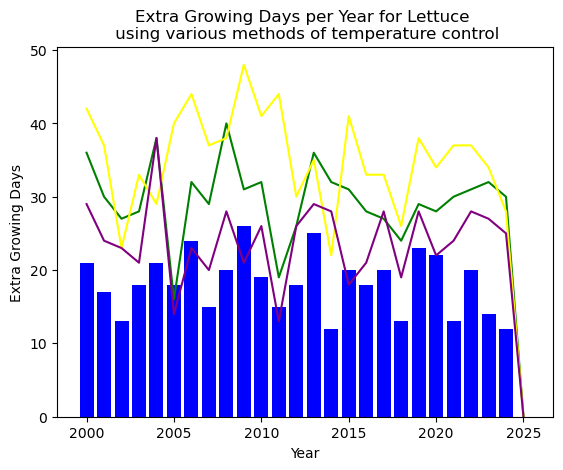

In [293]:
plt.subplot()
plt.bar(optimal_days_summary["year"], optimal_days_summary["optimal_days_greenhouse"], color='blue', label='Control')
plt.plot(optimal_days_summary["year"], optimal_days_summary["optimal_days_whitewash"], color='green', label='Whitewash')
plt.plot(optimal_days_summary["year"], optimal_days_summary["optimal_days_thermal"], color='yellow', label='Thermal')
plt.plot(optimal_days_summary["year"], optimal_days_summary["optimal_days_shade"], color='purple', label='Shade')

plt.title("Extra Growing Days per Year for Lettuce \n using various methods of temperature control")
  
plt.xlabel("Year")
plt.ylabel("Extra Growing Days")
plt.show()


## 9. Weather predictions using the station "10RIK" dataframe
Using the method in section [7](#7-analysing-the-weather-data) create a dataframe with all the data for station '10RIK' and ridge regression. This section is based on the excellent tutorial on YouTube called "Predict the Weather with Machine Learning Beginner Project" [(52)](https://www.youtube.com/watch?v=km95-NMT6lU&ab_channel=Dataquest).

The first thing we need to do is call a clean version of the dataframe, we are likely to do this a few times so I'll save it as a function.

In [31]:
def get_station_data(table_name, chosenstation):
    con = None
    try:
        # Connect to the database
        con = msql.connect(host='localhost', database='weather', user='root', password='')
    
        # If the connection is established
        if con.is_connected():
            cursor = con.cursor()
        
            # Execute the SQL query
            query =f"SELECT date, avg_temp, min_temp, max_temp FROM `{table_name}` WHERE station_id = %s"
            cursor.execute(query, (chosenstation,))
            rows = cursor.fetchall()
        
            # Create a DataFrame
            region_df2= pd.DataFrame(rows, columns = ['date', 'avg_temp', 'min_temp', 'max_temp'])

            # Return the result        
            return region_df2
        
    # Handle any errors
    except msql.Error as err: 
        print(err)
        return None

    # Close the cursor and connection
    finally:
        if con and con.is_connected():
            cursor.close()
            con.close()

Now call the dataframe.

In [40]:
table_name = "CA_ON_data"
chosenstation = "10RIK"

station_data = get_station_data(table_name, chosenstation)

print(station_data.head())

         date avg_temp min_temp max_temp
0  2000-01-01     -2.5    -11.0      6.0
1  2000-01-02      5.0     -2.0     12.0
2  2000-01-03     -0.3     -2.0      1.5
3  2000-01-04      4.5     -2.0     11.0
4  2000-01-05     -8.8    -11.5     -6.0


### 9.1 Check the returned data
Then count missing values using `.isnull` [(48)](https://www.atlassian.com/data/notebook/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe).

In [34]:
# Count missing values
print(station_data.isnull().sum())

date        0
avg_temp    0
min_temp    0
max_temp    0
dtype: int64


There are no missing values which is essential for machine learning. Now check that the data types are numerical.

In [35]:
print(station_data.dtypes)

date        object
avg_temp    object
min_temp    object
max_temp    object
dtype: object


All the data types are objects so we convert the date to datetime and the other columns to floats.

In [41]:
station_data["date"] = pd.to_datetime(station_data["date"])
station_data["avg_temp"] = station_data["avg_temp"].astype(float)
station_data["min_temp"] = station_data["min_temp"].astype(float)
station_data["max_temp"] = station_data["max_temp"].astype(float)

print(station_data.dtypes)

date        datetime64[ns]
avg_temp           float64
min_temp           float64
max_temp           float64
dtype: object


Set the date as the index for easier time series modelling using `.set_index` [(49)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html)

In [42]:
station_data.set_index("date", inplace=True)

print(station_data.head())

            avg_temp  min_temp  max_temp
date                                    
2000-01-01      -2.5     -11.0       6.0
2000-01-02       5.0      -2.0      12.0
2000-01-03      -0.3      -2.0       1.5
2000-01-04       4.5      -2.0      11.0
2000-01-05      -8.8     -11.5      -6.0


Visualise the data to check for any errors.

<Axes: title={'center': 'Average Temperature Over Time'}, xlabel='date'>

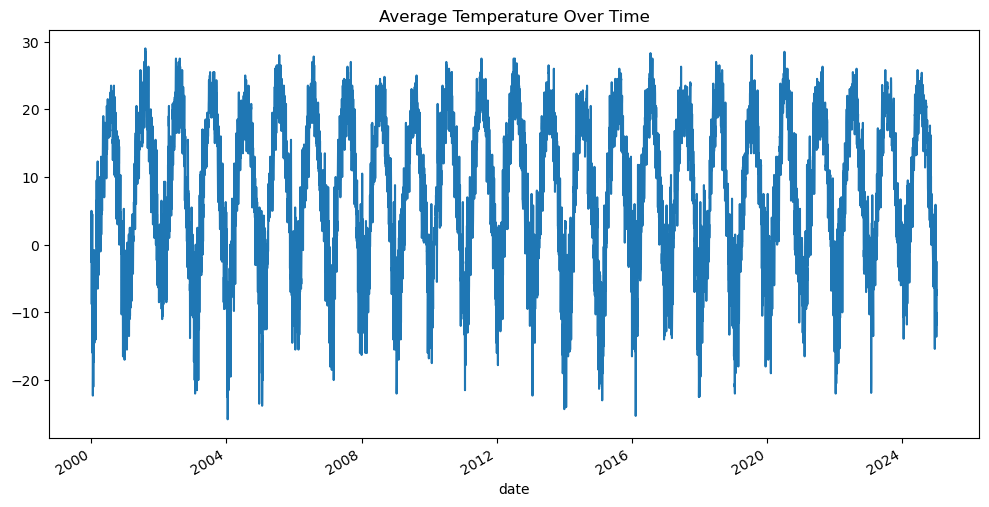

In [43]:
station_data["avg_temp"].plot(figsize=(12, 6), title="Average Temperature Over Time")

There appears to be no missing values or outliers. 

<Axes: title={'center': 'Minimum Temperature Over Time'}, xlabel='date'>

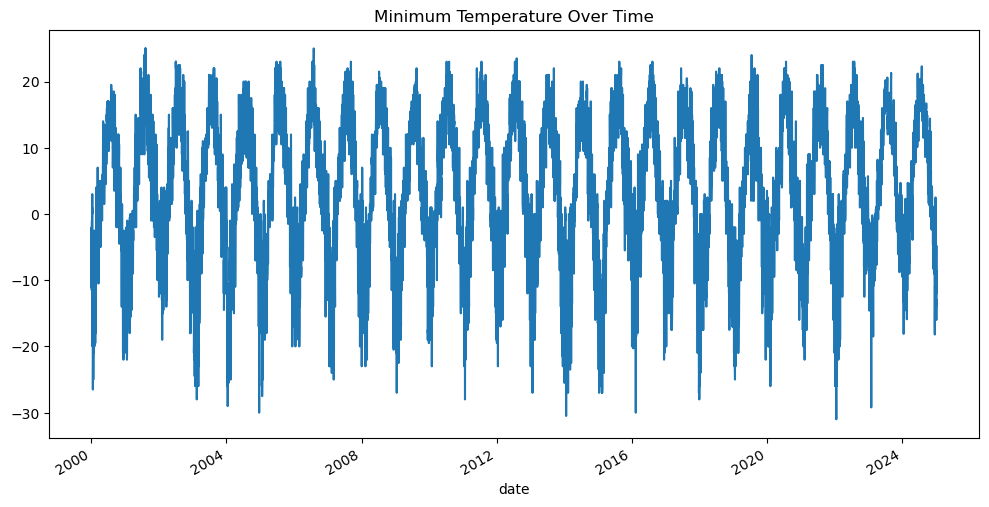

In [44]:
station_data["min_temp"].plot(figsize=(12, 6), title="Minimum Temperature Over Time")

<Axes: title={'center': 'Max Temperature Over Time'}, xlabel='date'>

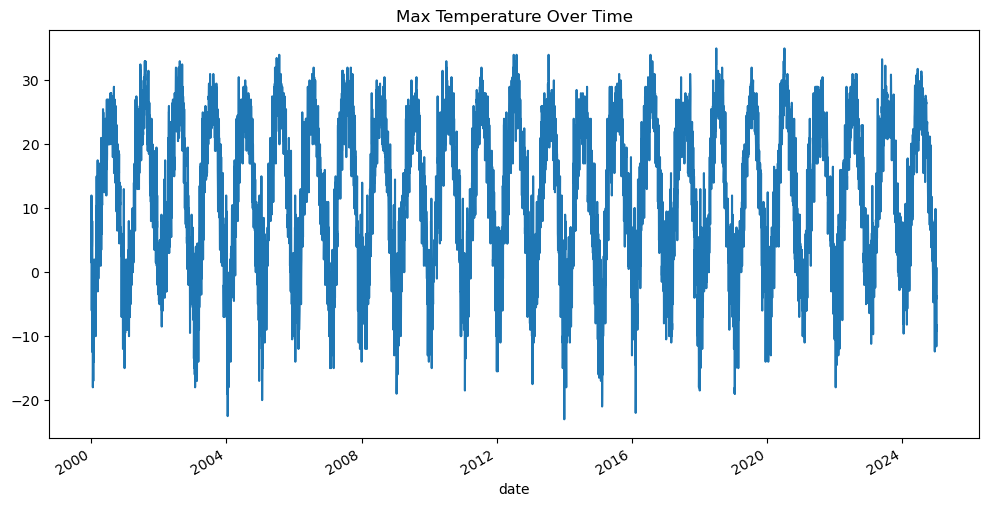

In [45]:
station_data["max_temp"].plot(figsize=(12, 6), title="Max Temperature Over Time")

### 9.2 Train our machine learning model using ridge regression
Using machine learning we can try to predict the maximum temperature for tomorrow. This section is based on the excellent tutorial on YoutBue by DataQuest [(52)](https://www.youtube.com/watch?v=km95-NMT6lU&ab_channel=Dataquest). 

The first step is to bring the weather back by one day in a new column. The last row will not have a 'target' value so can be removed.

In [46]:
# Create a new column with the next day's max temperature
station_data["target"] = station_data.shift(-1)["max_temp"]

# Drop the last row
station_data.drop(station_data.tail(1).index, inplace=True)

print(station_data.tail())

            avg_temp  min_temp  max_temp  target
date                                            
2025-01-08     -13.6     -16.0     -11.6    -8.5
2025-01-09     -11.2     -13.6      -8.5    -7.3
2025-01-10     -10.2     -12.8      -7.3    -3.7
2025-01-11      -6.7      -8.6      -3.7    -4.1
2025-01-12      -7.4     -12.0      -4.1     0.6


Now we can start on the regression model. We are going to use ridge [(50)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Ridge regression is well explained at [(54) https://www.geeksforgeeks.org/what-is-ridge-regression/](https://www.geeksforgeeks.org/what-is-ridge-regression/). Basically ridge regression helps when two or more predictor variables are highly correlated.

In [47]:
# Regression model
model = Ridge(alpha=0.5)

# Define the predictors
predictors = ["avg_temp", "min_temp", "max_temp"]

# Split the data into train and test
train = station_data[:"2019"] # Train data up to 2019
test = station_data["2020":] # Test data for 2020

# Fit the model
model.fit(train[predictors], train["target"])

# Predict the target
predictions = model.predict(test[predictors])

# Calculate the mean absolute error
fit_error= mean_absolute_error(test["target"], predictions)

# Print the error
print(f"The predictions were on average out by: {fit_error}")


The predictions were on average out by: 3.15069091767438


On average the predictions were 3.15 degrees Celsius away from the actual maximum temperature on that day.

### 9.3 Evaluate the model
Next we can manually look at the predicted temperatures versus the actual.

In [48]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["Actual", "Predicted"]
print(combined)

            Actual  Predicted
date                         
2020-01-01     6.0   2.752591
2020-01-02     6.0   6.454601
2020-01-03     2.0   6.422965
2020-01-04    -1.0   2.637365
2020-01-05     2.5  -0.141476
...            ...        ...
2025-01-08    -8.5  -9.527866
2025-01-09    -7.3  -7.238669
2025-01-10    -3.7  -6.122871
2025-01-11    -4.1  -3.483284
2025-01-12     0.6  -1.779345

[1817 rows x 2 columns]


<Axes: title={'center': 'Actual vs Predicted Max Temperature'}, xlabel='date'>

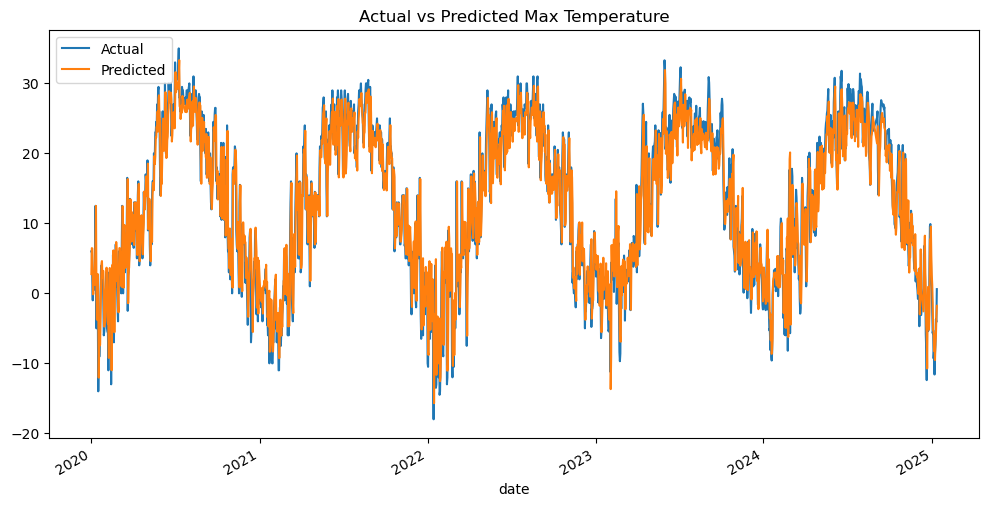

In [49]:
combined.plot(figsize=(12, 6), title="Actual vs Predicted Max Temperature")

The plot shows that our predictions are more conservative than what actually happened. By looking at the coefficients of the model we can see that the minimum temperature is a strong predictor of the maximum temperature on the next day.

In [452]:
model.coef_

array([ 1.67511192, -0.85853626,  0.10626298])

We are going to continue to refine the model so let's save a function to create the predictions.

In [50]:
def create_predictions(predictors, station_data, model):
    # Split the data into train and test
    train = station_data[:"2019"] # Train data up to 2019
    test = station_data["2020":] # Test data for 2020

    # Fit the model
    model.fit(train[predictors], train["target"])

    # Predict the target
    predictions = model.predict(test[predictors])

    # Calculate the mean absolute error
    fit_error = mean_absolute_error(test["target"], predictions)

    # Create a combined DataFrame
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["Actual", "Predicted"]
    
    # return the combined DataFrame and the mean absolute error
    return fit_error, combined


### 9.4 Create more predictors
Weather in a particular month is fairly similar and predictable, let's create some more predictors based on monthly averages. The first is based on a 30 days rolling average.

In [52]:
station_data["rolling_month_max"] = station_data["max_temp"].rolling(window=30).mean()
print(station_data.tail())

            avg_temp  min_temp  max_temp  target  rolling_month_max
date                                                               
2025-01-08     -13.6     -16.0     -11.6    -8.5          -1.403333
2025-01-09     -11.2     -13.6      -8.5    -7.3          -1.530000
2025-01-10     -10.2     -12.8      -7.3    -3.7          -1.756667
2025-01-11      -6.7      -8.6      -3.7    -4.1          -1.980000
2025-01-12      -7.4     -12.0      -4.1     0.6          -2.150000


Now let's create two more predictors

In [53]:
# Predictor based on the rolling monthly max temperature and the max temperature for that day
station_data["month_day_max"] = station_data["rolling_month_max"]/station_data["max_temp"]

# Predictor based on the relationship between the max and min temperature for that day
station_data["max_min_ratio"] = station_data["max_temp"]/station_data["min_temp"]

print(station_data.tail())

            avg_temp  min_temp  max_temp  target  rolling_month_max  \
date                                                                  
2025-01-08     -13.6     -16.0     -11.6    -8.5          -1.403333   
2025-01-09     -11.2     -13.6      -8.5    -7.3          -1.530000   
2025-01-10     -10.2     -12.8      -7.3    -3.7          -1.756667   
2025-01-11      -6.7      -8.6      -3.7    -4.1          -1.980000   
2025-01-12      -7.4     -12.0      -4.1     0.6          -2.150000   

            month_day_max  max_min_ratio  
date                                      
2025-01-08       0.120977       0.725000  
2025-01-09       0.180000       0.625000  
2025-01-10       0.240639       0.570312  
2025-01-11       0.535135       0.430233  
2025-01-12       0.524390       0.341667  


In [57]:
# Update the definition of the predictors
predictors = ["avg_temp", "min_temp", "max_temp", "rolling_month_max", "month_day_max", "max_min_ratio"]

In [58]:
# Remove the first 30 rows of the dataframe where there are no monthly predictions
station_data = station_data.dropna()

# Remove rows with infinity or extremely large values
station_data = station_data.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the fit error and create the combined DataFrame
fit_error, combined = create_predictions(predictors, station_data, model)

print(f"The fit error is now: {fit_error}")

The fit error is now: 2.916907046151641


These extra predictors have brought our fit error down to 2.91 degrees.

<Axes: title={'center': 'Actual vs Predicted Max Temperature'}, xlabel='date'>

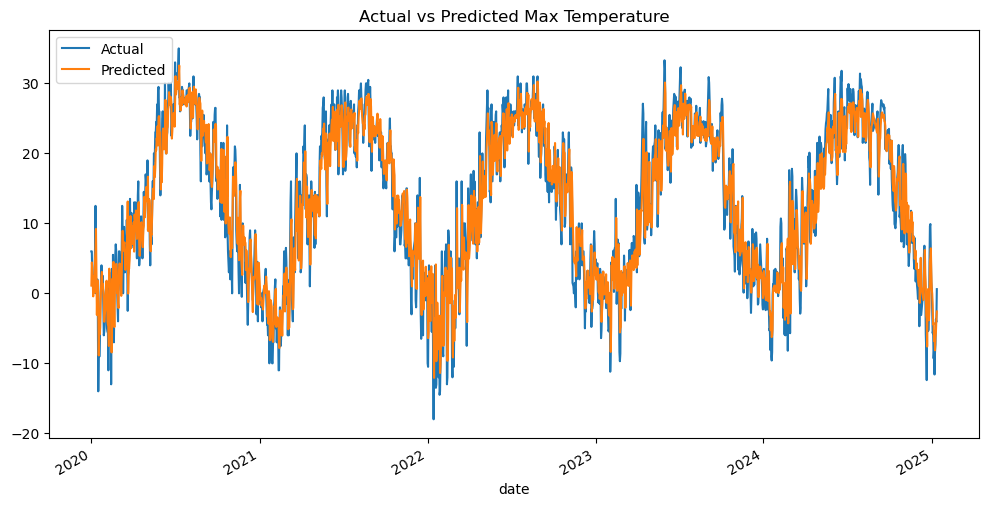

In [59]:
combined.plot(figsize=(12, 6), title="Actual vs Predicted Max Temperature")

The plot still indicates that the predicted values are slightly conservative.

### 9.5 Monthly average temperature predictions

To calculate the monthly average we can use `groupby` [(37)](https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/) to group the data by month and `transform` [(55)](https://www.w3schools.com/python/pandas/ref_df_transform.asp)to calculate the mean for each value in the dataframe.

In [64]:
station_data["monthly_avg"] = station_data.groupby(station_data.index.month)["max_temp"].transform("mean")

print(station_data.head())

            avg_temp  min_temp  max_temp  target  rolling_month_max  \
date                                                                  
2000-01-30      -5.8     -13.0       1.5     1.0          -3.316667   
2000-01-31      -0.8      -2.5       1.0    -1.5          -3.483333   
2000-02-01      -3.3      -5.0      -1.5    -7.5          -3.933333   
2000-02-02     -12.3     -17.0      -7.5    -9.0          -4.233333   
2000-02-03     -14.5     -20.0      -9.0    -6.0          -4.900000   

            month_day_max  max_min_ratio  monthly_avg  
date                                                   
2000-01-30      -2.211111      -0.115385    -3.077794  
2000-01-31      -3.483333      -0.400000    -3.077794  
2000-02-01       2.622222       0.300000    -1.521692  
2000-02-02       0.564444       0.441176    -1.521692  
2000-02-03       0.544444       0.450000    -1.521692  


To create the average maximum temperature for the day of the year from your dataframe, you can group the data by the day of the year and then calculate the mean for each group. 

In [67]:
# Find the day of the year
station_data["day_of_year"] = station_data.index.dayofyear  

# Create an average based on the day of the year
station_data["day_of_year_avg"] = station_data.groupby("day_of_year")["max_temp"].transform("mean")

# Print out the results
print(station_data.head())

            avg_temp  min_temp  max_temp  target  rolling_month_max  \
date                                                                  
2000-01-30      -5.8     -13.0       1.5     1.0          -3.316667   
2000-01-31      -0.8      -2.5       1.0    -1.5          -3.483333   
2000-02-01      -3.3      -5.0      -1.5    -7.5          -3.933333   
2000-02-02     -12.3     -17.0      -7.5    -9.0          -4.233333   
2000-02-03     -14.5     -20.0      -9.0    -6.0          -4.900000   

            month_day_max  max_min_ratio  monthly_avg  day_of_year  \
date                                                                 
2000-01-30      -2.211111      -0.115385    -3.077794           30   
2000-01-31      -3.483333      -0.400000    -3.077794           31   
2000-02-01       2.622222       0.300000    -1.521692           32   
2000-02-02       0.564444       0.441176    -1.521692           33   
2000-02-03       0.544444       0.450000    -1.521692           34   

           

Now we have created more predictors these should be added to our model.

In [70]:
predictors = ["avg_temp", "min_temp", "max_temp", "rolling_month_max", "month_day_max", "max_min_ratio", "monthly_avg", "day_of_year_avg"]    
fit_error, combined = create_predictions(predictors, station_data, model)

print(f"Our predictions are now {fit_error} degrees away from the actual values.")

Our predictions are now 2.8576562469833657 degrees away from the actual values.


If we look at the correlation of the different predictors against the "target" value, we can see that the average temperature, minimum aire, maximum air temperature, rolling month average and monthly average are good predictors for the maximum temperature tomorrow.

In [71]:
station_data.corr()["target"]

avg_temp             0.914641
min_temp             0.871471
max_temp             0.928717
target               1.000000
rolling_month_max    0.875927
month_day_max        0.080965
max_min_ratio        0.169486
monthly_avg          0.894554
day_of_year          0.253592
day_of_year_avg      0.905223
Name: target, dtype: float64

### 9.6 Evaluating our final ridge regression model
To evaluate the model it is good to look at where there was a big difference between the actual and the predicted values. Our biggest error was 14.2 degrees on 5 March 2022. Further analysis could be done to look into this.

In [73]:
combined["Difference"] = combined["Actual"] - combined["Predicted"]
combined.sort_values("Difference", ascending=False).head()

,Actual,Predicted,Difference
date,,,
2022-03-05,16.0,1.763797,14.236203
2024-03-03,17.8,4.395468,13.404532
2024-02-26,17.6,4.197767,13.402233
2022-02-15,9.0,-2.801151,11.801151
2022-03-16,16.0,4.566217,11.433783


### 9.7 How could we use this model to predict the weather on the same day of the year next year
First start by calling a clean dataframe for the same location.

In [105]:
table_name = "CA_ON_data"
chosenstation = "10RIK"

station_data1 = get_station_data(table_name, chosenstation)

print(station_data1.head())

         date avg_temp min_temp max_temp
0  2000-01-01     -2.5    -11.0      6.0
1  2000-01-02      5.0     -2.0     12.0
2  2000-01-03     -0.3     -2.0      1.5
3  2000-01-04      4.5     -2.0     11.0
4  2000-01-05     -8.8    -11.5     -6.0


Set up the dataframe with the correct datatypes and date as the index.

In [106]:
station_data1["date"] = pd.to_datetime(station_data1["date"])
station_data1["avg_temp"] = station_data1["avg_temp"].astype(float)
station_data1["min_temp"] = station_data1["min_temp"].astype(float)
station_data1["max_temp"] = station_data1["max_temp"].astype(float)
station_data1.set_index("date", inplace=True)

print(station_data1.head())


            avg_temp  min_temp  max_temp
date                                    
2000-01-01      -2.5     -11.0       6.0
2000-01-02       5.0      -2.0      12.0
2000-01-03      -0.3      -2.0       1.5
2000-01-04       4.5      -2.0      11.0
2000-01-05      -8.8     -11.5      -6.0


Create a target column based on the average temperature of the following day of the year.

In [107]:
station_data1["target"] = station_data1["avg_temp"].shift(-365)
# Drop the last row
station_data1.drop(station_data1.tail(365).index, inplace=True)

print(station_data1.tail())


            avg_temp  min_temp  max_temp  target
date                                            
2023-12-29       2.0       1.3       2.9   -11.2
2023-12-30      -0.7      -2.6       1.2   -10.2
2023-12-31      -3.7      -5.2      -1.6    -6.7
2024-01-01      -4.6      -7.7      -2.3    -7.4
2024-01-02      -1.2      -5.4       3.0    -2.6


Create an updated regression model function using the station_data1 data frame.

In [108]:
def create_predictions(predictors, station_data1, model):
    # Split the data into train and test
    train = station_data1[:"2019"] # Train data up to 2019
    test = station_data1["2020":] # Test data for 2020

    # Fit the model
    model.fit(train[predictors], train["target"])

    # Predict the target
    predictions = model.predict(test[predictors])

    # Calculate the mean absolute error
    fit_error = mean_absolute_error(test["target"], predictions)

    # Create a combined DataFrame
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["Actual", "Predicted"]
    
    # return the combined DataFrame and the mean absolute error
    return fit_error, combined


In [109]:
predictors = ["avg_temp", "min_temp", "max_temp"]

fit_error, combined = create_predictions(predictors, station_data, model)
print(f"The fit error is: {fit_error}")
print(combined)

The fit error is: 3.106349079370232
            Actual  Predicted
date                         
2020-01-01     6.0   2.855595
2020-01-02     6.0   6.516462
2020-01-03     2.0   6.535472
2020-01-05     2.5  -0.018596
2020-01-06     2.0   3.239428
...            ...        ...
2023-12-27     4.2   4.587556
2023-12-28     2.9   4.376636
2023-12-29     1.2   3.484375
2023-12-30    -1.6   2.058372
2023-12-31    -2.3  -0.896764

[1414 rows x 2 columns]


Our predictions were out by 3.1 degrees. Plotting the data will help to see the discrepancies.

<Axes: title={'center': 'Actual vs Predicted Average Temperature'}, xlabel='date'>

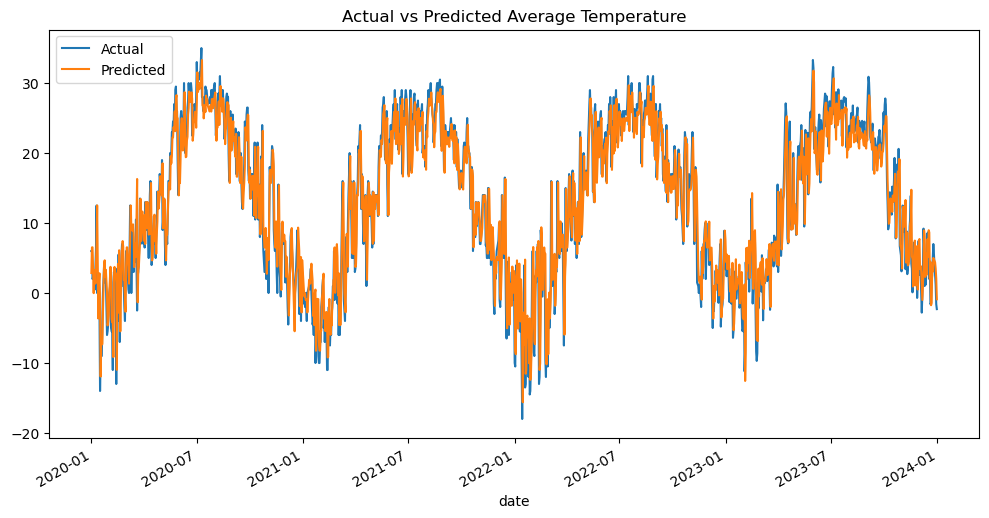

In [110]:
combined.plot(figsize=(12, 6), title="Actual vs Predicted Average Temperature")

The chart shows our model was optimistic about the temperature in January and February 2020 and the winter of 2021.

### 9.8 Adding more predictors to our annual temperature model
We can now add more predictors to our model based on the learning we did for predicting the next days weather.

In [111]:
# Create a new column based on the average temperature for the preceeding 30 days
station_data1["rolling_month_avg"] = station_data1["avg_temp"].rolling(window=30).mean()

# Predictor based on the rolling monthly max temperature and the max temperature for that day
station_data1["month_day_avg"] = station_data1["rolling_month_avg"]/station_data1["avg_temp"]

# Predictor based on the relationship between the max and min temperature for that day
station_data1["max_min_ratio"] = station_data1["max_temp"]/station_data1["min_temp"]

# Create a monthly average column
station_data1["monthly_avg"] = station_data1.groupby(station_data1.index.month)["avg_temp"].transform("mean")

# Find the day of the year
station_data1["day_of_year"] = station_data1.index.dayofyear  

# Create an average based on the day of the year
station_data1["day_of_year_avg"] = station_data1.groupby("day_of_year")["max_temp"].transform("mean")

# Remove rows with infinity or extremely large values
station_data1 = station_data1.replace([np.inf, -np.inf], np.nan).dropna()

Now we can update the list of predictors and re-run the model.

In [113]:
predictors = ["avg_temp", "min_temp", "max_temp", "rolling_month_avg", "month_day_avg", "max_min_ratio", "monthly_avg", "day_of_year_avg"]    
fit_error, combined = create_predictions(predictors, station_data1, model)

print(f"Our predictions are now {fit_error} degrees away from the actual values.")

Our predictions are now 3.2827362523481725 degrees away from the actual values.


<Axes: title={'center': 'Actual vs Predicted Average Temperature'}, xlabel='date'>

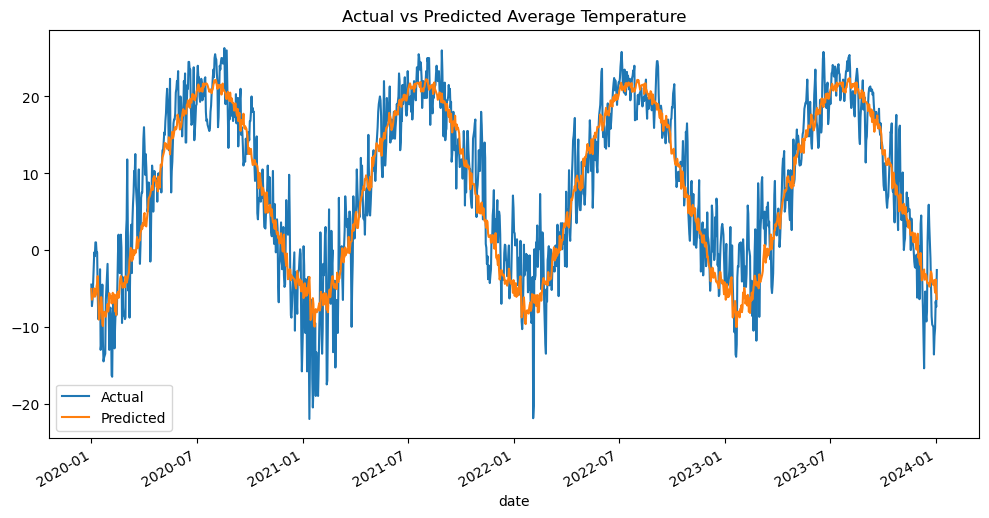

In [114]:
combined.plot(figsize=(12, 6), title="Actual vs Predicted Average Temperature")

Our predictions are now 3.2 degrees away from the actual values. Why is this data useful? We can now predict weather one year in advance being able to show a farmer that if the buy the thermal tool for this greenhouse now, how many extra growing days can they get next year.

## 10 Weather prediction with Random Forest Regressor
Another technique we could use for predicting the weather is random forest [(53)](https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/). Random forest regression is very widely used as it is simple and quick to train.

The first step is to call a clean dataframe of the station data.

In [74]:
table_name = "CA_ON_data"
chosenstation = "10RIK"

station_data1 = get_station_data(table_name, chosenstation)

print(station_data1.head())


         date avg_temp min_temp max_temp
0  2000-01-01     -2.5    -11.0      6.0
1  2000-01-02      5.0     -2.0     12.0
2  2000-01-03     -0.3     -2.0      1.5
3  2000-01-04      4.5     -2.0     11.0
4  2000-01-05     -8.8    -11.5     -6.0


Root Mean Squared Error: 3.52°C


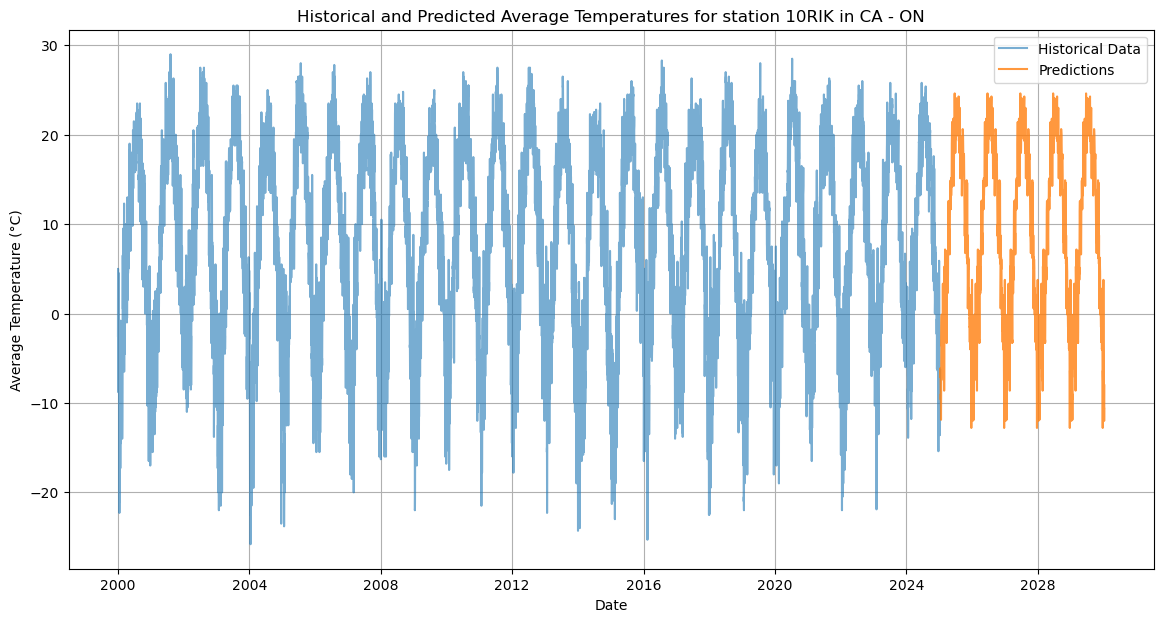

Predictions saved to 'predicted_temperatures.csv'


In [7]:

# Prepare Features
station_data1['date'] = pd.to_datetime(station_data1['date'])
station_data1['day_of_year'] = station_data1['date'].dt.dayofyear
station_data1['year'] = station_data1['date'].dt.year

# Features: Day of the year and year; Target: Average temperature
X = region_df3[['day_of_year', 'year']]
y = region_df3['avg_temp']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}°C")

# Predict for Next 5 Years
future_years = pd.date_range(start=region_df3['date'].max() + timedelta(days=1), 
                             periods=5 * 365, freq='D')
future_df = pd.DataFrame({
    'date': future_years,
    'day_of_year': future_years.day_of_year,
    'year': future_years.year
})
future_predictions = model.predict(future_df[['day_of_year', 'year']])
future_df['predicted_tavg'] = future_predictions

# Plot Known Data and Predictions
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(region_df3['date'], region_df3['avg_temp'], label='Historical Data', alpha=0.6)

# Plot predictions
plt.plot(future_df['date'], future_df['predicted_tavg'], label='Predictions', alpha=0.8)

plt.title(f'Historical and Predicted Average Temperatures for station {chosenstation} in {chosencountry} - {chosenregion}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

# Save Predictions
future_df.to_csv('predicted_temperatures.csv', index=False)
print(f"Predictions saved to 'predicted_temperatures.csv'")

The predicted temperatures show lower extremes particularly in winter than the actual.

## 11. Weather data clustering with KMeans
https://www.askpython.com/python/examples/weather-data-clustering

https://www.askpython.com/python/examples/weather-data-clustering

c:\Users\kirst\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


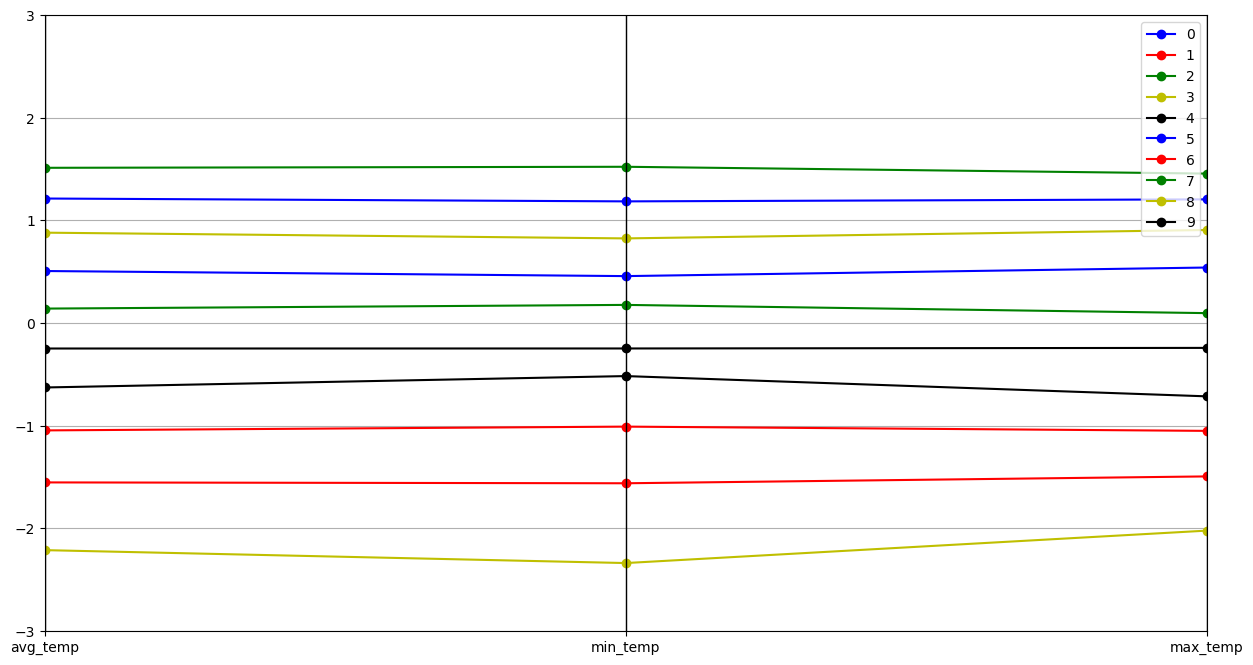

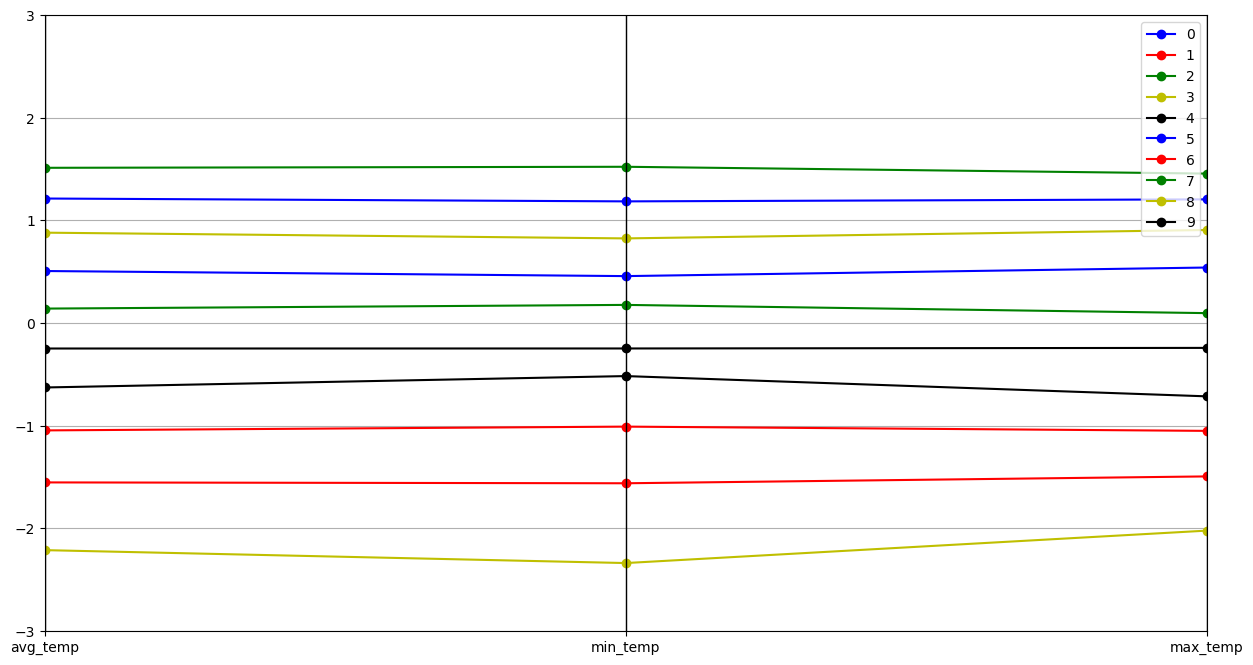

In [478]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

# Select every 10th row for faster processing

df.dropna(inplace=True)
sampled_df = df.iloc[::10]
sampled_df.shape

# Select features for clustering
features = ['avg_temp', 'min_temp', 'max_temp']
selected_df = sampled_df[features]

# Standardize the features
X = StandardScaler().fit_transform(selected_df)

# Apply KMenas clustering
KM = KMeans(n_clusters=10)
model = KM.fit(X)
centers = model.cluster_centers_

# Visualize the clusters

# 1. Function that generates a DataFrame with a Cluster Number column.
 
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
 
# 2. Function that creates Parallel Plots
 
def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
 
P = pd_centers(features, centers)

parallel_plot(P[P['min_temp'] < lettuce_range_low])
parallel_plot(P[P['avg_temp'] < lettuce_range_high])

## 12. Bibliography
1.	Environmental factors affecting plant growth | OSU Extension Service [Internet]. [cited 2025 Jan 11]. Available from: https://extension.oregonstate.edu/gardening/techniques/environmental-factors-affecting-plant-growth
2.	The Weather’s Record Keeper | Meteostat [Internet]. [cited 2025 Jan 11]. Available from: https://meteostat.net/en/
3.	MySQL :: MySQL Connector/Python Developer Guide [Internet]. [cited 2025 Jan 11]. Available from: https://dev.mysql.com/doc/connector-python/en/
4.	Python’s Requests Library (Guide) – Real Python [Internet]. [cited 2025 Jan 11]. Available from: https://realpython.com/python-requests/
5.	gzip — Support for gzip files — Python 3.13.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://docs.python.org/3/library/gzip.html
6.	Stringio And Bytesio For Managing Data As File Object - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/stringio-and-bytesio-for-managing-data-as-file-object/
7.	Working With JSON Data in Python – Real Python [Internet]. [cited 2025 Jan 11]. Available from: https://realpython.com/python-json/
8.	pandas - Python Data Analysis Library [Internet]. [cited 2025 Jan 11]. Available from: https://pandas.pydata.org/
9.	datetime — Basic date and time types — Python 3.13.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://docs.python.org/3/library/datetime.html
10.	NumPy - [Internet]. [cited 2025 Jan 11]. Available from: https://numpy.org/
11.	matplotlib.pyplot — Matplotlib 3.5.3 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
12.	seaborn: statistical data visualization — seaborn 0.13.2 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://seaborn.pydata.org/
13.	r2_score — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
14.	RandomForestRegressor — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
15.	Random Forest Regression in Python - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/random-forest-regression-in-python/
16.	train_test_split — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
17.	Split Your Dataset With scikit-learn’s train_test_split() – Real Python [Internet]. [cited 2025 Jan 11]. Available from: https://realpython.com/train-test-split-python-data/
18.	mean_squared_error — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
19.	Python | Mean Squared Error - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/python-mean-squared-error/
20.	datetime — Basic date and time types — Python 3.13.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://docs.python.org/3/library/datetime.html
21.	Statistical functions (scipy.stats) — SciPy v1.15.0 Manual [Internet]. [cited 2025 Jan 11]. Available from: https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html
22.	decimal — Decimal fixed-point and floating-point arithmetic — Python 3.13.1 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://docs.python.org/3/library/decimal.html
23.	Plot Multiple lines in Matplotlib - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/
24.	matplotlib.pyplot.scatter — Matplotlib 3.10.0 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
25.	pandas.DataFrame.dropna — pandas 2.2.3 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
26.	linregress — SciPy v1.15.1 Manual [Internet]. [cited 2025 Jan 11]. Available from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
27.	Python Machine Learning Linear Regression [Internet]. [cited 2025 Jan 11]. Available from: https://www.w3schools.com/python/python_ml_linear_regression.asp
28.	Graphs of polynomials (article) | Khan Academy [Internet]. [cited 2025 Jan 11]. Available from: https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:poly-graphs/x2ec2f6f830c9fb89:poly-graphs-together/a/graphs-of-polynomials
29.	(406) Polynomial fit using Numpy module in Python - YouTube [Internet]. [cited 2025 Jan 11]. Available from: https://www.youtube.com/watch?v=-Ovf9yAFhqI&ab_channel=ShameelAbdulla
30.	Weather Stations | Bulk Data | Meteostat Developers [Internet]. [cited 2025 Jan 11]. Available from: https://dev.meteostat.net/bulk/stations.html#endpoints
31.	Python MySQL Creating Tables - Javatpoint [Internet]. [cited 2025 Jan 11]. Available from: https://www.javatpoint.com/python-mysql-creating-tables
32.	Gzip - GNU Project - Free Software Foundation [Internet]. [cited 2025 Jan 11]. Available from: https://www.gnu.org/software/gzip/
33.	Python 3, read/write compressed json objects from/to gzip file - Stack Overflow [Internet]. [cited 2025 Jan 11]. Available from: https://stackoverflow.com/questions/39450065/python-3-read-write-compressed-json-objects-from-to-gzip-file
34.	SQL SELECT DISTINCT Statement [Internet]. [cited 2025 Jan 11]. Available from: https://www.w3schools.com/SQL/sql_distinct.asp
35.	Querying Data from a Database using fetchone() and fetchall() - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/querying-data-from-a-database-using-fetchone-and-fetchall/
36.	pandas.DataFrame.iterrows — pandas 2.2.3 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
37.	Pandas dataframe.groupby() Method - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/
38.	pandas.core.groupby.GroupBy.mean — pandas 0.25.0 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.core.groupby.GroupBy.mean.html
39.	pandas.unique — pandas 2.2.3 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.unique.html
40.	Lettuce | NC State Extension Publications [Internet]. [cited 2025 Jan 11]. Available from: https://content.ces.ncsu.edu/lettuce
41.	What are the Ideal Conditions for Greenhouse Tomatoes? - DryGair [Internet]. [cited 2025 Jan 11]. Available from: https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/
42.	matplotlib.pyplot.axhline — Matplotlib 3.10.0 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html#matplotlib.pyplot.axhline
43.	matplotlib.pyplot.xticks — Matplotlib 3.10.0 documentation [Internet]. [cited 2025 Jan 11]. Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
44.	How to Place Legend Outside of the Plot in Matplotlib? - GeeksforGeeks [Internet]. [cited 2025 Jan 11]. Available from: https://www.geeksforgeeks.org/how-to-place-legend-outside-of-the-plot-in-matplotlib/
45.	Pandas Pivot Tables: A Comprehensive Guide for Data Science | Qodo [Internet]. [cited 2025 Jan 11]. Available from: https://www.qodo.ai/blog/pandas-pivot-tables-a-comprehensive-guide-for-data-science/
46.	python - In pandas, what’s the difference between df[’column’] and df.column? - Stack Overflow [Internet]. [cited 2025 Jan 11]. Available from: https://stackoverflow.com/questions/23546555/in-pandas-whats-the-difference-between-dfcolumn-and-df-column
47.	numpy.where() in Python - GeeksforGeeks [Internet]. [cited 2025 Jan 12]. Available from: https://www.geeksforgeeks.org/numpy-where-in-python/
48.	NaN Detection in Pandas | Atlassian [Internet]. [cited 2025 Jan 12]. Available from: https://www.atlassian.com/data/notebook/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
49.	pandas.DataFrame.set_index — pandas 2.2.3 documentation [Internet]. [cited 2025 Jan 12]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
50.	Ridge — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 12]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
51.	mean_absolute_error — scikit-learn 1.6.1 documentation [Internet]. [cited 2025 Jan 12]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
52.	(413) Predict The Weather with Machine Learning: Beginner Project - YouTube [Internet]. [cited 2025 Jan 12]. Available from: https://www.youtube.com/watch?v=km95-NMT6lU&ab_channel=Dataquest
53.	Random Forest Algorithm in Machine Learning - GeeksforGeeks [Internet]. [cited 2025 Jan 12]. Available from: https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/
